In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
import json
import seaborn as sns

%matplotlib inline

In [2]:
path = "C:/Users/mchukwu/Desktop/sgpcore_newyork/extracted_monthly_patterns/extracted_monthly_patterns.csv"

In [3]:
with open(path,'rb') as f:
    df = pd.read_csv(f)

In [4]:
df.columns = df.columns.str.lower()

In [5]:
df['poi_geoid'] = df['poi_cbg'].apply(lambda x: '{:.0f}'.format(x))

In [6]:
# check for null columns and drop them
threshold = int(0.8 * len(df))
df = df.dropna(axis=1,thresh=threshold)

In [7]:
def vertically_explode_json(df_, json_column='visitor_home_cbgs', key_col_name='visitor_home_cbg', value_col_name='cbg_visitor_count'):
    # This function vertically explodes a JSON column in SafeGraph Patterns
    # The resulting dataframe has one row for every data element in all the JSON of all the original rows
    # This is a slow step. If you are working with more than 20,000 rows you should explore faster implementations like pyspark
    #, see here: https://docs.safegraph.com/docs/faqs#section-how-do-i-work-with-the-patterns-columns-that-contain-json

    # Inputs
    #    df -- a pandas.DataFrame -- dataframe with a unique df.index for every row
    #    json_column -- each element of this column is a stringified json blog. No elements can be NULL. # TODO: convert NA JSON columns
    #to empty `{}` so function can handle them and just pass those rows through
    #    key_col_name -- arbitrary string, the name of the column in the output which contains the keys of the key:values of the JSON
    #    value_col_name -- arbitrary string, the name of the column in the output which contains the values of the key:values of the JSON
    # Outputs
    #    df -- a pandas.DataFrame with 2 new columns
    #    1) key_col_name
    #    2) value_col_name

    df = df_.copy()
    if(df.index.unique().shape[0] < df.shape[0]):
        raise("ERROR -- non-unique index found")
    df[json_column+'_dict'] = [json.loads(cbg_json) for cbg_json in df[json_column]]
    all_sgpid_cbg_data = [] # each cbg data point will be one element in this list
    for index, row in df.iterrows():
      # extract each key:value inside each visitor_home_cbg dict (2 nested loops)
      this_sgpid_cbg_data = [ {'orig_index' : index, key_col_name:key, value_col_name:value} for key,value in row[json_column+'_dict'].items() ]
      all_sgpid_cbg_data = all_sgpid_cbg_data + this_sgpid_cbg_data
    output = pd.DataFrame(all_sgpid_cbg_data)
    output.set_index('orig_index', inplace=True)
    return(output)

def explode_visitor_home_cbg(df, json_column='visitor_home_cbgs', key_col_name='visitor_home_cbg', value_col_name='cbg_visitor_count', keep_index=False):
    if(keep_index):
        df['index_original'] = df.index
    df = df.dropna(subset = [json_column]).copy() # Drop nan jsons
    df.reset_index(drop=True, inplace=True) # Every row must have a unique index
    df_exp = vertically_explode_json(df, json_column=json_column, key_col_name=key_col_name, value_col_name=value_col_name)
    df = df.merge(df_exp, left_index=True, right_index=True).reset_index(drop=True)
    return(df)


In [8]:
%%time
visitor_pattern = explode_visitor_home_cbg(df)

CPU times: total: 37 s
Wall time: 39.5 s


In [9]:
# filter to census code 36081|36047|36085|36061|36005
sgcore_df = visitor_pattern[(visitor_pattern['visitor_home_cbg'].str.match('36081|36047|36085|36061|36005') == True) & 
(visitor_pattern['location_name'].str.contains('Park|park|playground|Playground') == True)]

In [10]:
# drop visitor_count less than 5: SafeGraph applies noise to visit less than 5 as 4; that means if the actual visit is 1,2,3 or 4, SafeGraph
# records that as 4.
sgcore_df = sgcore_df[sgcore_df['cbg_visitor_count']>= 5]

In [11]:
cols_to_bring = [ 'date_range_start',
 'date_range_end',
 'placekey',
 'location_name',
 'latitude',
 'longitude',
 'poi_geoid',
 'visitor_home_cbg',
 'cbg_visitor_count',
 'raw_visit_counts',
 'raw_visitor_counts',
 'distance_from_home',
 'median_dwell','normalized_visits_by_total_visits']
sgcore_df = sgcore_df[cols_to_bring]

In [12]:
sgcore_df['visits_by_cbg'] = sgcore_df.apply(lambda x: round(x['cbg_visitor_count'] * (x['raw_visit_counts'] / x['raw_visitor_counts'])), axis=1)


In [13]:
sgcore_df.shape

(103638, 15)

### What is the nature of visits across CBGS in NYC?

In [14]:
pd.options.mode.chained_assignment = None 
## visualizing visits across CBGs

In [15]:
sgcoreV = sgcore_df.copy()

In [16]:
# Convert date_range_start and date_range_end to datetime

sgcoreV['date_range_start'] = pd.to_datetime(sgcoreV['date_range_start'])
sgcoreV['date_range_end'] = pd.to_datetime(sgcoreV['date_range_end'])


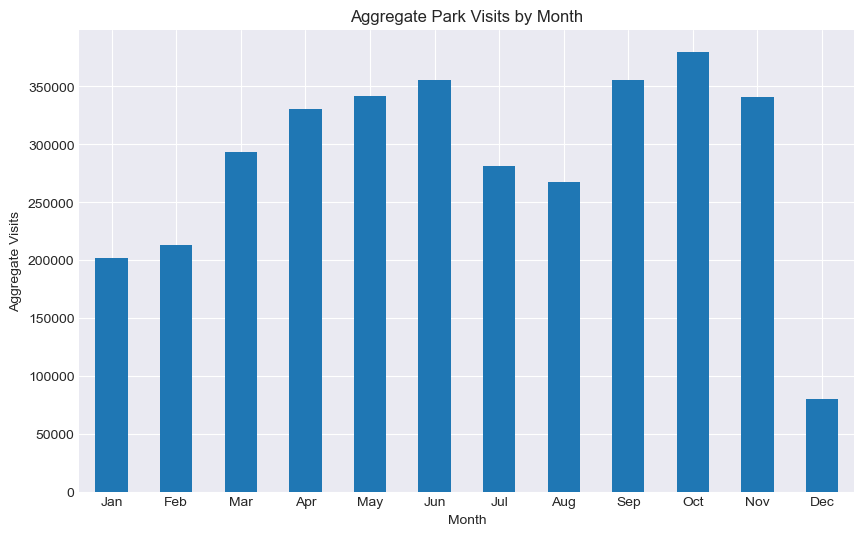

In [17]:
# Extract the month from 'date_range_start'
sgcoreV['month'] = sgcoreV['date_range_start'].dt.month

# Group the data by month and calculate the total number of visits for each month
monthly_visits = sgcoreV.groupby('month')['visits_by_cbg'].sum()
plt.style.use('seaborn-v0_8-darkgrid')

plt.figure(figsize=(10, 6))
monthly_visits.plot(kind='bar')
plt.title('Aggregate Park Visits by Month')
plt.xlabel('Month')
plt.ylabel('Aggregate Visits')
plt.xticks(ticks=range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
#plt.savefig('Aggregate Monthly Visits.png',dpi=600)

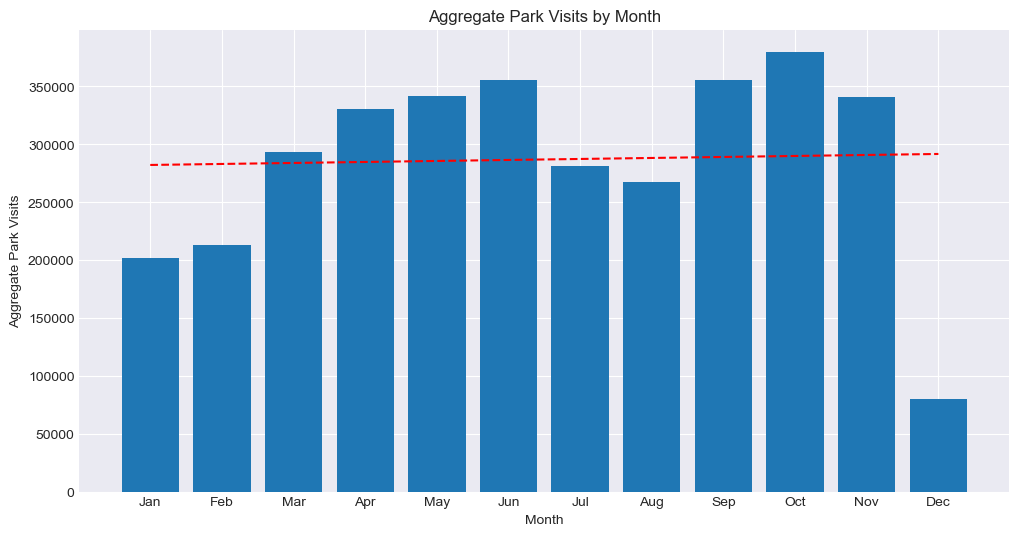

In [18]:
# Extract x and y values
x = sgcoreV['month'].unique()
y = sgcoreV.groupby('month')['visits_by_cbg'].sum()

# Fit a linear regression model
model = np.polyfit(x, y, 1)

# Create the plot
plt.figure(figsize=(12, 6))
plt.bar(x, y)
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
plt.xlabel('Month')
plt.xlabel('Month')
plt.ylabel('Aggregate Park Visits')
plt.title('Aggregate Park Visits by Month')

# Plot the trendline
plt.plot(x, model[0] * x + model[1], color='red', linestyle='--')
#plt.savefig('Aggregate_Park_Monthly_Visits_Trend.png',dpi=600)

In [19]:
# convert datetime to week to visualize weekly visits

sgcoreV['week'] = sgcoreV['date_range_start'].dt.dayofweek

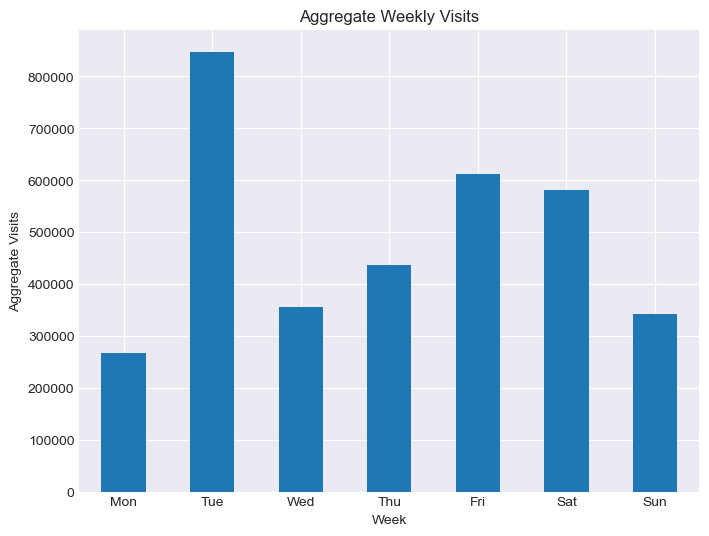

In [20]:
# Group the data by week and calculate the total number of visits for each week
weekly_visits = sgcoreV.groupby('week')['visits_by_cbg'].sum()
plt.style.use('seaborn-v0_8-darkgrid')

plt.figure(figsize=(8, 6))
weekly_visits.plot(kind='bar')
plt.title('Aggregate Weekly Visits')
plt.xlabel('Week')
plt.ylabel('Aggregate Visits')
plt.xticks(ticks=range(0, 7), labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], rotation=0)
#plt.savefig('Aggregate Park Weekly Visits.png',dpi=600)

## Group CBGs by Visits, Dwell Time, and Distance threshold

In [21]:
visit_per_cbg = sgcoreV.groupby('visitor_home_cbg')[['visits_by_cbg','median_dwell','distance_from_home']].sum()#.to_frame([['Frequency of Visits','median_dwell','distance_from_home']])
visit_per_cbg = pd.DataFrame(visit_per_cbg)

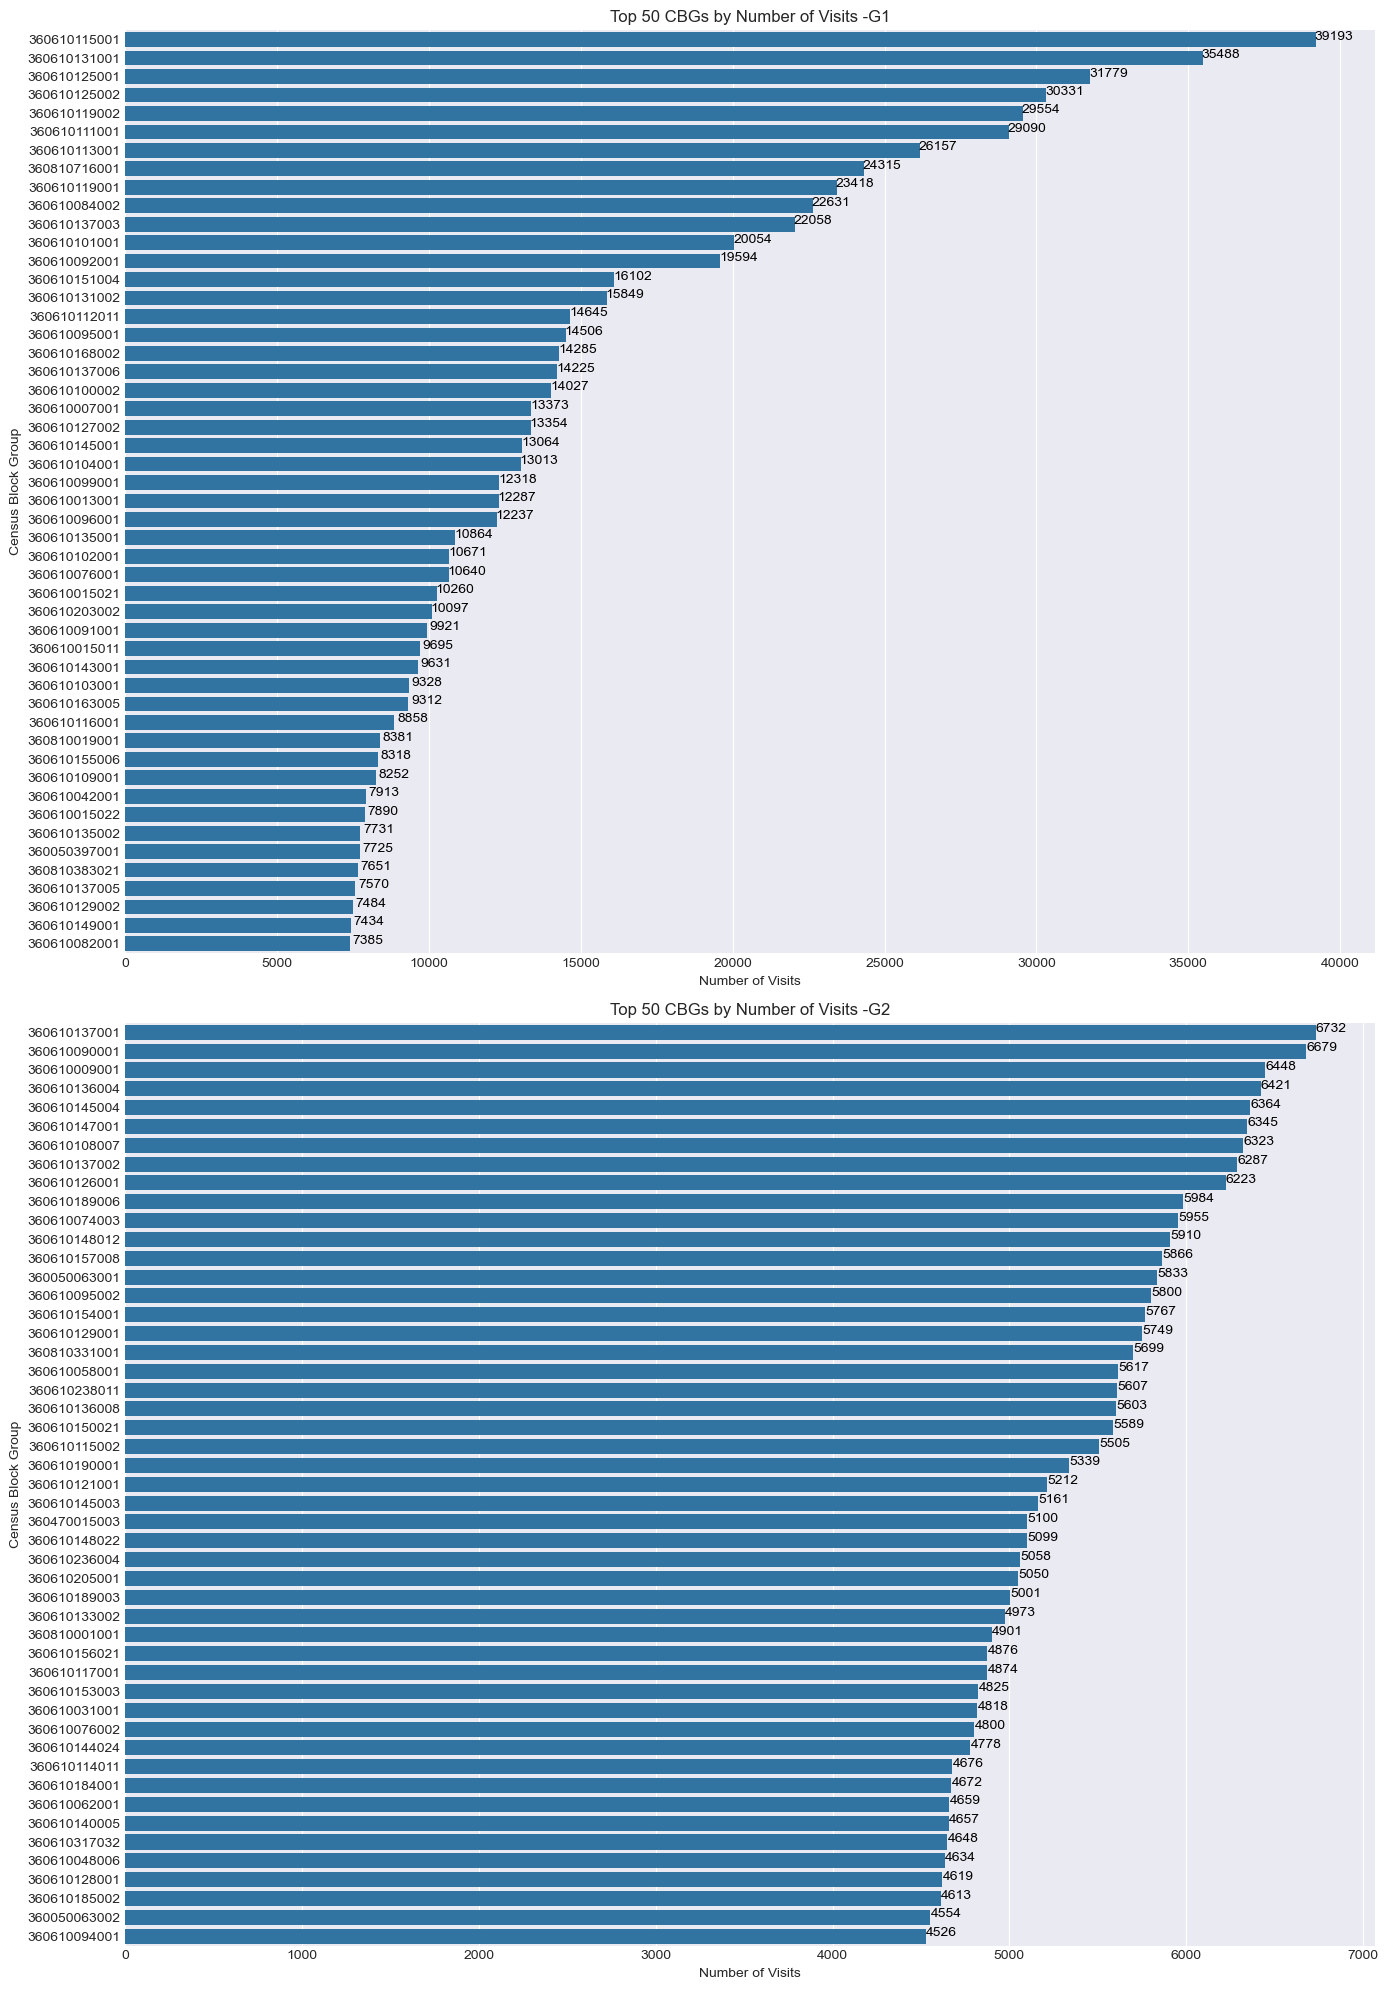

In [22]:
# Sort the DataFrame to get the top 20 and bottom 20 census block groups by the number of visits
third_50_visits = visit_per_cbg.sort_values('visits_by_cbg', ascending=False).head(50)
fourth_50_visits = visit_per_cbg.sort_values('visits_by_cbg', ascending=False).iloc[51:100]

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 20))

# Plot the top 20 census blocks with most visits
sns.barplot(x='visits_by_cbg', y=third_50_visits.index, data=third_50_visits, ax=axes[0], orient='h')
axes[0].set_title('Top 50 CBGs by Number of Visits -G1')
axes[0].set_xlabel('Number of Visits')
axes[0].set_ylabel('Census Block Group')

# Add values inside the bars for the top 20
for index, value in enumerate(third_50_visits['visits_by_cbg']):
    axes[0].text(value + 600, index, f'{value}', color='black', ha="center")

# Plot the bottom 20 census blocks with least visits
sns.barplot(x='visits_by_cbg', y=fourth_50_visits.index, data=fourth_50_visits, ax=axes[1], orient='h')
axes[1].set_title('Top 50 CBGs by Number of Visits -G2')
axes[1].set_xlabel('Number of Visits')
axes[1].set_ylabel('Census Block Group')

# Add values inside the bars for the bottom 20
for index, value in enumerate(fourth_50_visits['visits_by_cbg']):
    axes[1].text(value + 90, index, f'{value}', color='black', ha="center")

# Adjust layout for better readability
plt.tight_layout()
#plt.savefig('Top 50 CBGs.png',dpi=300)

In [23]:
len(visit_per_cbg[visit_per_cbg['visits_by_cbg'] <=300])

2862

In [24]:
low_visitor_cbg = visit_per_cbg[visit_per_cbg['visits_by_cbg'] <=300]

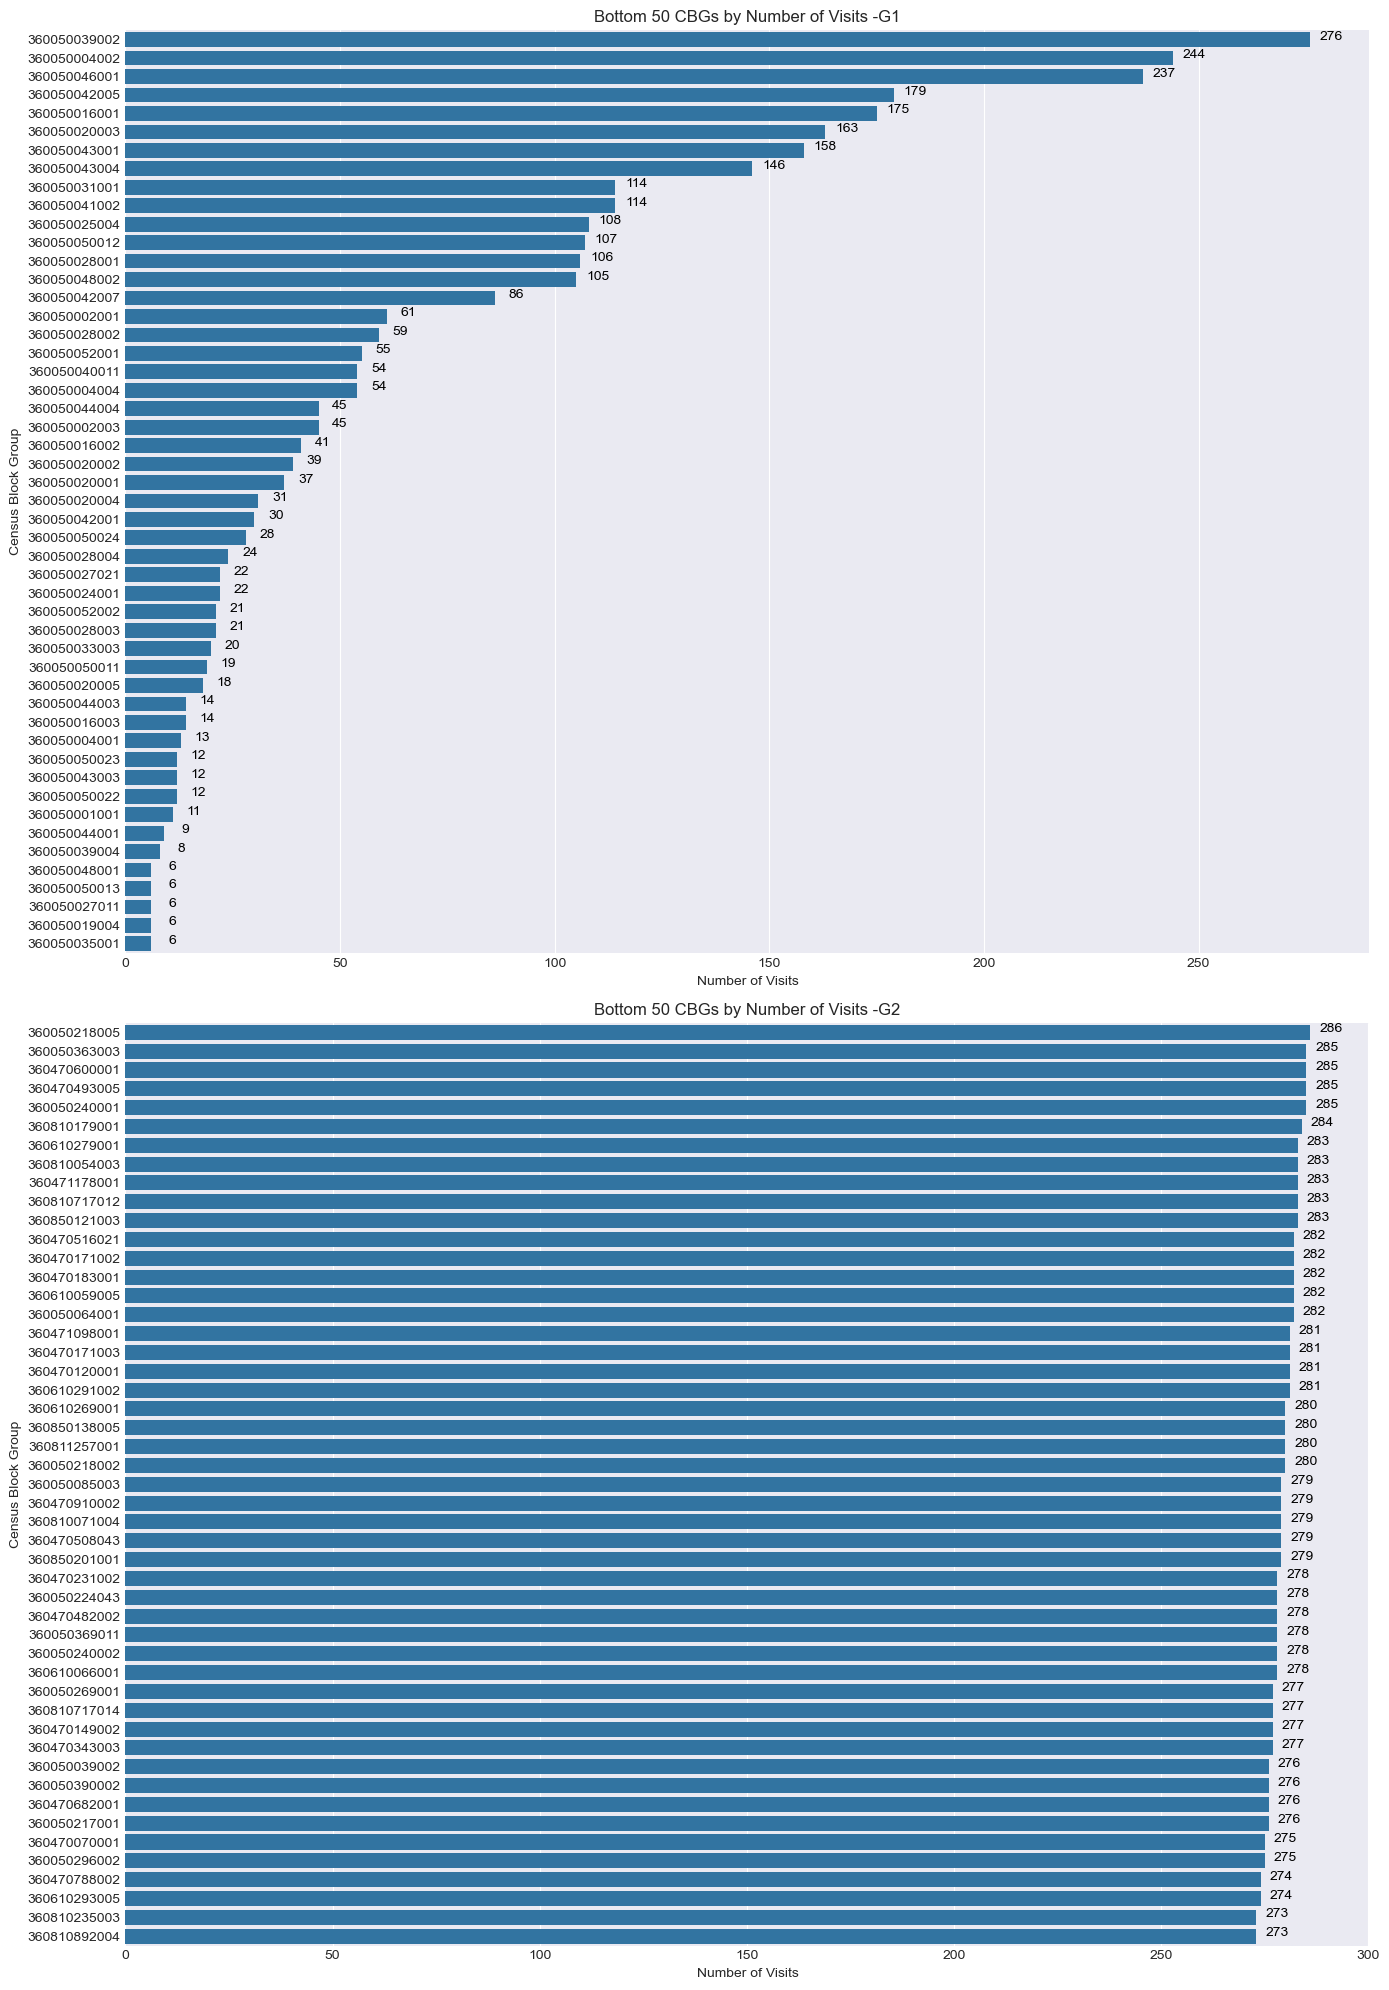

In [25]:
# Sort the DataFrame to get the top 20 and bottom 20 census block groups by the number of visits
low_visitor_cbg_first50 = low_visitor_cbg.head(50).sort_values(by='visits_by_cbg',ascending=False)
low_visitor_cbg_first50_100 = low_visitor_cbg.sort_values(by='visits_by_cbg',ascending=False).iloc[51:100]


# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 20))

# Plot the top 20 census blocks with most visits
sns.barplot(x='visits_by_cbg', y=low_visitor_cbg_first50.index, data=low_visitor_cbg_first50, ax=axes[0], orient='h')
axes[0].set_title('Bottom 50 CBGs by Number of Visits -G1')
axes[0].set_xlabel('Number of Visits')
axes[0].set_ylabel('Census Block Group')

# Add values inside the bars for the top 20
for index, value in enumerate(low_visitor_cbg_first50['visits_by_cbg']):
    axes[0].text(value + 5, index, f'{value}', color='black', ha="center")

# Plot the bottom 20 census blocks with least visits
sns.barplot(x='visits_by_cbg', y=low_visitor_cbg_first50_100.index, data=low_visitor_cbg_first50_100, ax=axes[1], orient='h')
axes[1].set_title('Bottom 50 CBGs by Number of Visits -G2')
axes[1].set_xlabel('Number of Visits')
axes[1].set_ylabel('Census Block Group')

# Add values inside the bars for the bottom 20
for index, value in enumerate(low_visitor_cbg_first50_100['visits_by_cbg']):
    axes[1].text(value + 5, index, f'{value}', color='black', ha="center")

# Adjust layout for better readability
plt.tight_layout()
#plt.savefig('Bottom 50 CBGs.png',dpi=300)

In [26]:
# more study focused on CBGs with low visit to understand the disparity

low_visitor_home_cbg = visit_per_cbg.copy()

In [27]:
low_visitor_home_cbg = low_visitor_home_cbg[low_visitor_home_cbg['visits_by_cbg']<=300]

In [28]:
low_visitor_home_cbg

,visits_by_cbg,median_dwell,distance_from_home
visitor_home_cbg,,,
360050001001,11,1.0,15556.0
360050002001,61,9.0,195331.0
360050002003,45,6.0,174630.0
360050004001,13,2.0,61514.0
360050004002,244,159.0,572192.0
...,...,...,...
360850303023,206,171.0,193848.0
360850303024,18,38.0,18052.0
360850319021,234,384.0,36981.0


In [29]:
high_visitor_home_cbg = visit_per_cbg.copy()

In [30]:
high_visitor_home_cbg = high_visitor_home_cbg[high_visitor_home_cbg['visits_by_cbg']>300]

In [31]:
high_visitor_home_cbg

,visits_by_cbg,median_dwell,distance_from_home
visitor_home_cbg,,,
360050002002,370,128.0,751613.0
360050004003,1461,1504.0,1545405.0
360050016004,545,651.0,790474.0
360050019001,2000,2071.0,1265755.0
360050038001,449,702.0,317044.0
...,...,...,...
360850303011,479,333.0,363007.0
360850303021,358,230.0,266903.0
360850319011,1272,432.0,32469.0


## load socioeconomic data from census bureau (ACS 2018 -2022)

In [35]:
socio_df = pd.read_csv('socioeconomic.csv')

In [36]:
socio_df

,FIPS,per_capita_income,male,female,median_income,white,black,asian,others,15_17y,...,masters,prof_sch,doctorate,employed,unemployed,car,public_trans,walk,15mins,45mins
0,360010001001,36493.0,289,435,54050.0,351,212,25,15,7,...,34,19,19,317,27,184,61,8,81.85,11.85
1,360010001002,14825.0,720,815,33750.0,399,777,5,265,171,...,36,28,0,544,127,323,115,45,76.91,18.51
2,360010002011,33451.0,41,204,50481.0,37,174,0,0,0,...,14,0,0,129,0,82,47,0,63.57,17.83
3,360010002012,15049.0,819,618,17490.0,140,1125,72,0,61,...,78,78,34,660,124,358,210,0,68.84,27.46
4,360010002013,55546.0,459,324,85603.0,211,478,30,23,19,...,150,105,0,541,0,151,0,234,75.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16065,361231504005,34479.0,453,565,142000.0,1007,11,0,0,8,...,113,29,7,418,43,255,0,81,39.07,17.21
16066,361231505011,32759.0,574,1084,58583.0,1563,0,0,95,24,...,146,32,0,754,12,715,0,3,62.26,29.53
16067,361231505012,39596.0,331,344,78438.0,571,0,78,26,48,...,53,13,13,385,6,290,0,40,61.43,0.00
16068,361231505021,36082.0,919,893,67083.0,1796,2,0,0,145,...,100,24,3,722,32,475,2,27,58.01,8.43


In [37]:
# convert FIPS from int to text data type
socio_df['FIPS'] = socio_df['FIPS'].astype(str)

In [38]:
# filter to location in New york city: Bronx, Queens, Kings, Brooklyn, Staten Island
socio_df = socio_df[socio_df['FIPS'].str.match('36085|36047|36081|36061|36005')]

In [39]:
# drop rows with NAN
socio_df = socio_df.dropna()

In [40]:
socio_df

,FIPS,per_capita_income,male,female,median_income,white,black,asian,others,15_17y,...,masters,prof_sch,doctorate,employed,unemployed,car,public_trans,walk,15mins,45mins
289,360050002001,32210.0,693,517,123208.0,257,508,43,296,46,...,185,52,36,506,0,353,116,37,88.74,30.24
290,360050002002,39257.0,1100,1011,115764.0,169,784,32,875,0,...,337,0,0,1143,65,457,376,185,96.68,51.79
291,360050002003,27074.0,762,787,81622.0,324,181,224,686,39,...,149,0,0,663,43,274,371,0,100.00,81.24
294,360050004002,26913.0,728,676,71230.0,59,396,8,862,59,...,0,0,0,718,44,421,247,0,91.36,42.34
295,360050004003,42310.0,1751,1798,129469.0,362,1084,155,1374,305,...,389,71,0,1553,223,870,491,0,96.21,46.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12867,360850319012,29070.0,663,584,93547.0,182,430,200,78,109,...,170,0,0,629,16,335,206,40,93.57,56.68
12869,360850319021,18196.0,404,751,17052.0,368,592,10,69,90,...,55,0,0,372,12,143,189,0,100.00,44.71
12870,360850319022,37295.0,845,1000,160500.0,191,1283,100,133,147,...,126,0,0,924,11,438,441,34,94.09,51.70
12871,360850319023,31366.0,1185,868,125217.0,393,717,107,580,153,...,60,0,0,956,32,679,206,41,74.62,25.38


In [41]:
# regroup education to low_education, high_education, elderly

#socio_df['low_edu'] = socio_df[['less_high_sch', 'high_sch']].sum(axis=1)
#socio_df['high_edu'] = socio_df[['some_college', 'bachelor', 'masters', 'prof_sch', 'doctorate']].sum(axis=1)
socio_df['young'] = socio_df[['15_17y', '18_24y', '25_34y']].sum(axis=1)
socio_df['adult'] = socio_df[['35_44y', '35_44y', '55_64y']].sum(axis=1)
socio_df['elderly'] = socio_df[['65_74y', '75_84y', '85y+']].sum(axis=1)

In [42]:
socio_df['tot_sex'] = socio_df[['male','female']].sum(axis=1)
socio_df['tot_pop'] = socio_df[['white','black','asian','others']].sum(axis=1)
socio_df['tot_age'] = socio_df[['elderly','young','adult']].sum(axis=1)
socio_df['tot_unemp'] = socio_df[['employed','unemployed']].sum(axis=1)
socio_df['tot_commute'] = socio_df[['15mins','45mins']].sum(axis=1)
socio_df['tot_transport'] = socio_df[['car','public_trans','walk']].sum(axis=1)
socio_df['tot_edu'] = socio_df[['less_high_sch','high_sch']].sum(axis=1)

In [43]:
# calculate percent for race, education, transportation,traveltime

socio_df['pct_male'] = (socio_df['male'] / socio_df['tot_sex']*100).round(2)
socio_df['pct_female'] = (socio_df['female'] / socio_df['tot_sex']*100).round(2)
socio_df['pct_white'] = (socio_df['white'] / socio_df['tot_pop']*100).round(2)
socio_df['pct_black'] = (socio_df['black'] / socio_df['tot_pop']*100).round(2)
socio_df['pct_asian'] = (socio_df['asian'] / socio_df['tot_pop']*100).round(2)
socio_df['pct_others'] = (socio_df['others'] / socio_df['tot_pop']*100).round(2)
socio_df['pct_young'] = (socio_df['young'] / socio_df['tot_age']*100).round(2)
socio_df['pct_adult'] = (socio_df['adult'] / socio_df['tot_age']*100).round(2)
socio_df['pct_elderly'] = (socio_df['elderly'] / socio_df['tot_age']*100).round(2)
socio_df['pct_low_edu'] = (socio_df['less_high_sch'] / socio_df['tot_edu']*100).round(2)
socio_df['pct_high_edu'] = (socio_df['high_sch'] / socio_df['tot_edu']*100).round(2)
socio_df['pct_short_comute'] = (socio_df['15mins'] / socio_df['tot_commute']*100).round(2)
socio_df['pct_long_comute'] = (socio_df['45mins'] / socio_df['tot_commute']*100).round(2)
socio_df['pct_unemp'] = (socio_df['unemployed'] / socio_df['tot_unemp']*100).round(2)
socio_df['pct_emp'] = (socio_df['employed'] / socio_df['tot_unemp']*100).round(2)
socio_df['pct_car'] = (socio_df['car'] / socio_df['tot_transport']*100).round(2)
socio_df['pct_public_trans'] = (socio_df['public_trans'] / socio_df['tot_transport']*100).round(2)
socio_df['pct_0car'] = (socio_df['walk'] / socio_df['tot_transport']*100).round(2)

In [44]:
socio_df_copy = socio_df.copy()

In [45]:
# Define income thresholds (reference: Census Bureau and Poverty Tracker)
Median_income = 81000

socio_df_copy['pct_low_income'] = (socio_df_copy['median_income'] < Median_income).astype(int)
socio_df_copy['pct_high_income'] = (socio_df_copy['median_income'] >= Median_income).astype(int)

In [46]:
socio_df_1 = socio_df_copy.copy()

In [47]:
socio_df_1 = socio_df_1[['FIPS','per_capita_income','median_income','pct_male','pct_female','pct_white','pct_black',
        'pct_asian','pct_others','pct_low_edu', 'pct_high_edu','pct_young','pct_adult', 'pct_elderly',
       'pct_short_comute', 'pct_long_comute', 'pct_car', 'pct_public_trans',
       'pct_0car','pct_unemp', 'pct_emp', 'pct_low_income', 'pct_high_income']]

In [48]:
# merge safegraph data with socio_df_1 data

merged_df = socio_df_1.merge(visit_per_cbg,left_on='FIPS',right_on='visitor_home_cbg')#.drop('visitor_home_cbg',axis=1)

In [49]:
merged_df = merged_df.groupby('FIPS').first().reset_index()

In [50]:
merged_df

,FIPS,per_capita_income,median_income,pct_male,pct_female,pct_white,pct_black,pct_asian,pct_others,pct_low_edu,...,pct_car,pct_public_trans,pct_0car,pct_unemp,pct_emp,pct_low_income,pct_high_income,visits_by_cbg,median_dwell,distance_from_home
0,360050002001,32210.0,123208.0,57.27,42.73,23.28,46.01,3.89,26.81,15.53,...,69.76,22.92,7.31,0.00,100.00,0,1,61,9.0,195331.0
1,360050002002,39257.0,115764.0,52.11,47.89,9.09,42.15,1.72,47.04,17.74,...,44.89,36.94,18.17,5.38,94.62,0,1,370,128.0,751613.0
2,360050002003,27074.0,81622.0,49.19,50.81,22.90,12.79,15.83,48.48,10.21,...,42.48,57.52,0.00,6.09,93.91,0,1,45,6.0,174630.0
3,360050004002,26913.0,71230.0,51.85,48.15,4.45,29.89,0.60,65.06,14.31,...,63.02,36.98,0.00,5.77,94.23,1,0,244,159.0,572192.0
4,360050004003,42310.0,129469.0,49.34,50.66,12.17,36.44,5.21,46.18,24.10,...,63.92,36.08,0.00,12.56,87.44,0,1,1461,1504.0,1545405.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3799,360850319012,29070.0,93547.0,53.17,46.83,20.45,48.31,22.47,8.76,37.98,...,57.66,35.46,6.88,2.48,97.52,0,1,381,434.0,54804.0
3800,360850319021,18196.0,17052.0,34.98,65.02,35.42,56.98,0.96,6.64,33.89,...,43.07,56.93,0.00,3.12,96.88,1,0,234,384.0,36981.0
3801,360850319022,37295.0,160500.0,45.80,54.20,11.19,75.16,5.86,7.79,13.86,...,47.97,48.30,3.72,1.18,98.82,0,1,429,404.0,250813.0
3802,360850319023,31366.0,125217.0,57.72,42.28,21.87,39.90,5.95,32.28,18.61,...,73.33,22.25,4.43,3.24,96.76,0,1,188,374.0,62975.0


## Statistical Analysis

## Do sociodemographic variables influence visit to Urban Parks in NYC?

In [51]:
import scipy

from scipy import stats

### income category ---> low income category

In [52]:
# Filter for pct_low_income
low_income_subset = merged_df[merged_df['pct_low_income'] == 1]

# Calculate median median_income for low-income group
median_income_threshold = low_income_subset['median_income'].median()

# Create a new column for the subgroup
merged_df['low_income_subgroup'] = 'low_income_low_median'
merged_df.loc[merged_df['median_income'] > median_income_threshold, 'low_income_subgroup'] = 'low_income_high_median'

In [53]:
# Group data by subgroup
grouped_data = merged_df.groupby('low_income_subgroup')['visits_by_cbg'].apply(list)

# Extract data for ANOVA
group1 = grouped_data['low_income_low_median']
group2 = grouped_data['low_income_high_median']

In [54]:
# Check the sizes of the groups
print(f"Low Income Group Size: {len(group1)}")
print(f"High Income Group Size: {len(group2)}")

Low Income Group Size: 926
High Income Group Size: 2878


In [55]:
## check ANOVA assumption

# 1) normality test 
# 2) test for equal variance

# Normality test
statistic, p_value = stats.shapiro(group1)
print("Shapiro-Wilk test for group 1:", statistic, p_value)

# Homogeneity of variances test
statistic, p_value = stats.levene(group1, group2)
print("Levene's test:", statistic, p_value)

Shapiro-Wilk test for group 1: 0.26762940176283845 5.51184342284713e-51
Levene's test: 9.086475000749173 0.0025920678861014847


In [56]:
statistic, p_value = stats.kruskal(group1, group2)

print("Kruskal-Wallis test:", statistic, p_value)

Kruskal-Wallis test: 1.1781139533553844 0.27774029185914695


Text(0, 0.5, 'Log(Visits by CBG)')

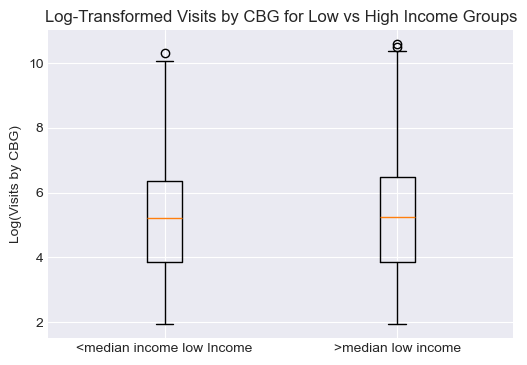

In [57]:
# Apply log transformation to the 'visits_by_cbg' values
log_group_low_income = np.log1p(group1)  # log1p is used to avoid issues with log(0)
log_group_high_income = np.log1p(group2)

# Plot the log-transformed data
plt.figure(figsize=(6, 4))
plt.boxplot([log_group_low_income, log_group_high_income], 
            labels=['<median income low Income', '>median low income'])
plt.title('Log-Transformed Visits by CBG for Low vs High Income Groups')
plt.ylabel('Log(Visits by CBG)')


### Race category ---> Black group

In [58]:
# Step 1: Create two groups based on the median of 'pct_black'
median_black_threshold = merged_df['pct_black'].median()

# Create two groups: low percentage of blacks and high percentage of blacks
group_low_black = merged_df[merged_df['pct_black'] < median_black_threshold]['visits_by_cbg']
group_high_black = merged_df[merged_df['pct_black'] >= median_black_threshold]['visits_by_cbg']

In [59]:
# Check the sizes of the groups
print(f"Low Black Group Size: {len(group_low_black)}")
print(f"High Black Group Size: {len(group_high_black)}")

Low Black Group Size: 1900
High Black Group Size: 1904


In [60]:
statistic, p_value = stats.kruskal(group_low_black, group_high_black)

print("Kruskal-Wallis test:", statistic, p_value)

Kruskal-Wallis test: 141.71468633082236 1.122708970622564e-32


Text(0, 0.5, 'Log(Visits by CBG)')

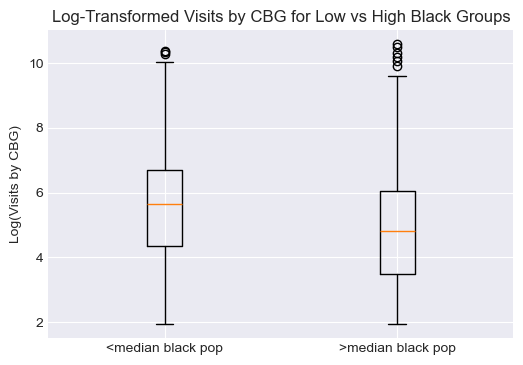

In [61]:
# Apply log transformation to the 'visits_by_cbg' values
log_group_low_black = np.log1p(group_low_black)  # log1p is used to avoid issues with log(0)
log_group_high_black = np.log1p(group_high_black)

# Plot the log-transformed data
plt.figure(figsize=(6, 4))
plt.boxplot([log_group_low_black, log_group_high_black], 
            labels=['<median black pop', '>median black pop'])
plt.title('Log-Transformed Visits by CBG for Low vs High Black Groups')
plt.ylabel('Log(Visits by CBG)')


### Gender ---> Female 

In [62]:
# Step 1: Create two groups based on the median of 'pct_female'
median_female = merged_df['pct_female'].median()

# Create two groups: low percentage of females and high percentage of females
group_low_female = merged_df[merged_df['pct_female'] < median_female]['visits_by_cbg']
group_high_female = merged_df[merged_df['pct_female'] >= median_female]['visits_by_cbg']

In [63]:
# Check the sizes of the groups
print(f"Low Female Group Size: {len(group_low_female)}")
print(f"High Female Group Size: {len(group_high_female)}")

Low Female Group Size: 1902
High Female Group Size: 1902


In [64]:
statistic, p_value = stats.kruskal(group_low_female, group_high_female)

print("Kruskal-Wallis test:", statistic, p_value)

Kruskal-Wallis test: 0.18194475818415065 0.6697072457220593


Text(0, 0.5, 'Log(Visits by CBG)')

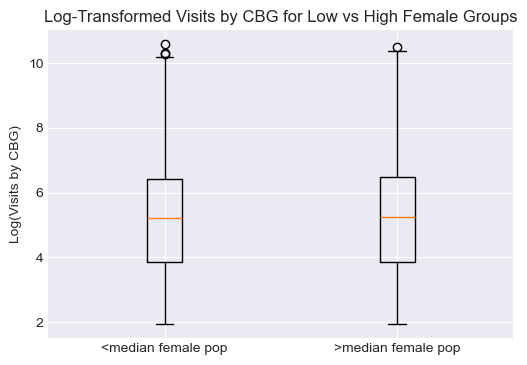

In [65]:
# Apply log transformation to the 'visits_by_cbg' values
log_group_low_female = np.log1p(group_low_female)  # log1p is used to avoid issues with log(0)
log_group_high_female = np.log1p(group_high_female)

# Plot the log-transformed data
plt.figure(figsize=(6, 4))
plt.boxplot([log_group_low_female, log_group_high_female], 
            labels=['<median female pop', '>median female pop'])
plt.title('Log-Transformed Visits by CBG for Low vs High Female Groups')
plt.ylabel('Log(Visits by CBG)')


### Unemployed Group --->

In [66]:
# Step 1: Create two groups based on the median of 'pct_unemp'
median_unemp = merged_df['pct_unemp'].median()

# Create two groups: low percentage of females and high percentage of females
group_low_unemp = merged_df[merged_df['pct_unemp'] < median_unemp]['visits_by_cbg']
group_high_unemp = merged_df[merged_df['pct_unemp'] >= median_unemp]['visits_by_cbg']

In [67]:
# Check the sizes of the groups
print(f"Low Unemployed Group Size: {len(group_low_unemp)}")
print(f"High Unemployed Group Size: {len(group_high_unemp)}")

Low Unemployed Group Size: 1898
High Unemployed Group Size: 1906


In [68]:
statistic, p_value = stats.kruskal(group_low_unemp, group_high_unemp)

print("Kruskal-Wallis test:", statistic, p_value)

Kruskal-Wallis test: 15.65997474297466 7.58116697810718e-05


Text(0, 0.5, 'Log(Visits by CBG)')

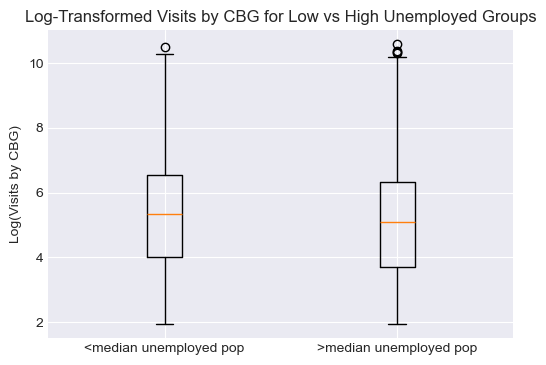

In [69]:
# Apply log transformation to the 'visits_by_cbg' values
log_group_low_unemp = np.log1p(group_low_unemp)  # log1p is used to avoid issues with log(0)
log_group_high_unemp = np.log1p(group_high_unemp)

# Plot the log-transformed data
plt.figure(figsize=(6, 4))
plt.boxplot([log_group_low_unemp, log_group_high_unemp], 
            labels=['<median unemployed pop', '>median unemployed pop'])
plt.title('Log-Transformed Visits by CBG for Low vs High Unemployed Groups')
plt.ylabel('Log(Visits by CBG)')

### Education ---> less than high school vs high school

In [70]:
# Step 1: Create two groups based on the median of 'pct_low_edu vs pct_high_edu'

merged_df[['pct_low_edu','pct_high_edu','visits_by_cbg']]

,pct_low_edu,pct_high_edu,visits_by_cbg
0,15.53,84.47,61
1,17.74,82.26,370
2,10.21,89.79,45
3,14.31,85.69,244
4,24.10,75.90,1461
...,...,...,...
3799,37.98,62.02,381
3800,33.89,66.11,234
3801,13.86,86.14,429
3802,18.61,81.39,188


In [71]:
merged_edu = merged_df.copy()

In [72]:
# Create a new column to categorize rows based on education level
merged_edu['education_category'] = merged_edu.apply(lambda row: 'low_edu' if row['pct_low_edu'] > row['pct_high_edu'] else ('high_edu' if row['pct_high_edu'] > row['pct_low_edu'] else 'mixed'), axis=1)

In [73]:
less_highsch = merged_edu[merged_edu['education_category']=='low_edu']['visits_by_cbg']
highsch = merged_edu[merged_edu['education_category']=='high_edu']['visits_by_cbg']

In [74]:
statistic, p_value = stats.kruskal(less_highsch, highsch)

print("Kruskal-Wallis test:", statistic, p_value)

Kruskal-Wallis test: 6.75848318877627 0.009330303651756931


Text(0, 0.5, 'Log(Visits by CBG)')

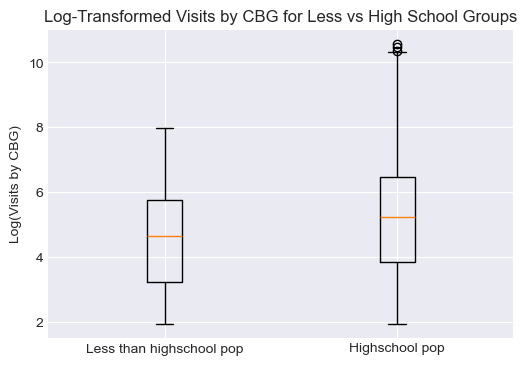

In [75]:
# Apply log transformation to the 'visits_by_cbg' values
log_group_less_highsch = np.log1p(less_highsch)  # log1p is used to avoid issues with log(0)
log_group_highsch = np.log1p(highsch)

# Plot the log-transformed data
plt.figure(figsize=(6, 4))
plt.boxplot([log_group_less_highsch, log_group_highsch], 
            labels=['Less than highschool pop', 'Highschool pop'])
plt.title('Log-Transformed Visits by CBG for Less vs High School Groups')
plt.ylabel('Log(Visits by CBG)')

## Age

In [76]:
merged_age = merged_df.copy()

In [77]:
def categorize_age(row):
    if row['pct_young'] > row['pct_elderly'] and row['pct_young'] > row['pct_adult']:
        return 'young'
    elif row['pct_adult'] > row['pct_elderly'] and row['pct_adult'] > row['pct_young']:
        return 'adult'
    elif row['pct_elderly'] > row['pct_young'] and row['pct_elderly'] > row['pct_adult']:
        return 'elderly'
    else:
        return 'mix'


merged_age['age_category'] = merged_age.apply(categorize_age,axis=1)

In [78]:
young_pop = merged_age[merged_age['age_category'] == 'young']['visits_by_cbg']
adult_pop = merged_age[merged_age['age_category'] == 'adult']['visits_by_cbg']
elderly_pop = merged_age[merged_age['age_category'] == 'elderly']['visits_by_cbg']

In [79]:
statistic, p_value = stats.kruskal(young_pop, adult_pop,elderly_pop)

print("Kruskal-Wallis test:", statistic, p_value)

Kruskal-Wallis test: 11.535113009667436 0.003127389947680469


Text(0, 0.5, 'Log(Visits by CBG)')

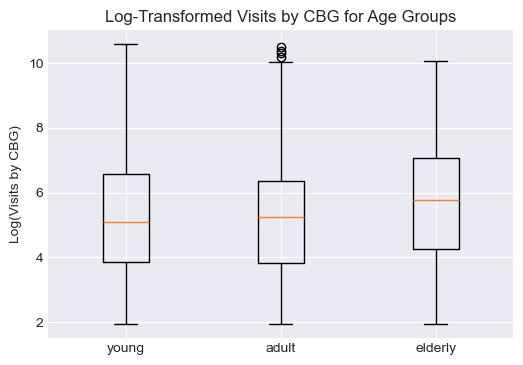

In [80]:
# Apply log transformation to the 'visits_by_cbg' values
young_group = np.log1p(young_pop)  # log1p is used to avoid issues with log(0)
adult_group = np.log1p(adult_pop)
elderly_group = np.log1p(elderly_pop)

# Plot the log-transformed data
plt.figure(figsize=(6, 4))
plt.boxplot([young_group, adult_group,elderly_group], 
            labels=['young', 'adult','elderly'])
plt.title('Log-Transformed Visits by CBG for Age Groups')
plt.ylabel('Log(Visits by CBG)')

### Transportation

In [81]:
merged_transport = merged_df.copy()

In [82]:
def categorize_transport(row):
    if row['pct_car'] > row['pct_0car'] and row['pct_car'] > row['pct_public_trans']:
        return 'car'
    elif row['pct_0car'] > row['pct_car'] and row['pct_0car'] > row['pct_public_trans']:
        return 'no_car'
    elif row['pct_public_trans'] > row['pct_car'] and row['pct_public_trans'] > row['pct_0car']:
        return 'public_trans'
    else:
        return 'mixed'  # In case of ties or equal values

# Apply the function to each row in the DataFrame to create the 'transport_category' column
merged_transport['transport_category'] = merged_transport.apply(categorize_transport, axis=1)

In [83]:
car_pop = merged_transport[merged_transport['transport_category'] == 'car']['visits_by_cbg']
no_car_pop = merged_transport[merged_transport['transport_category'] == 'no_car']['visits_by_cbg']
public_trans_pop = merged_transport[merged_transport['transport_category'] == 'public_trans']['visits_by_cbg']

In [84]:
statistic, p_value = stats.kruskal(car_pop, no_car_pop,public_trans_pop)

print("Kruskal-Wallis test:", statistic, p_value)

Kruskal-Wallis test: 183.84837521337045 1.1962792478225975e-40


Text(0, 0.5, 'Log(Visits by CBG)')

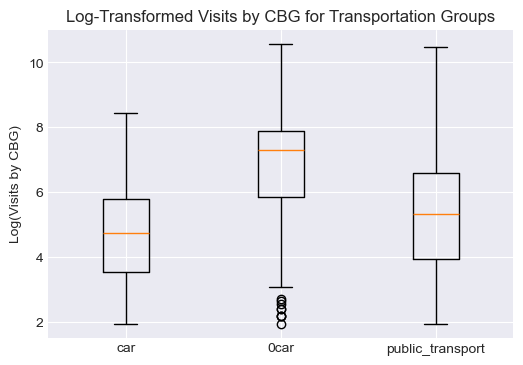

In [85]:
# Apply log transformation to the 'visits_by_cbg' values
car_group = np.log1p(car_pop)  # log1p is used to avoid issues with log(0)
no_car_group = np.log1p(no_car_pop)
public_trans_group = np.log1p(public_trans_pop)

# Plot the log-transformed data
plt.figure(figsize=(6, 4))
plt.boxplot([car_group, no_car_group,public_trans_group], 
            labels=['car', '0car','public_transport'])
plt.title('Log-Transformed Visits by CBG for Transportation Groups')
plt.ylabel('Log(Visits by CBG)')

### Commute distance

In [86]:
merged_commute = merged_df.copy()

In [87]:
# define a function that creates commute_category and returns the dominant commute in any row

def categorize_commute(row):
    if row['pct_short_comute'] > row['pct_long_comute'] and row['pct_short_comute'] >=70:
        return 'pct_short_comute'
    else:
        return 'pct_long_comute'

merged_commute['commute_category'] = merged_commute.apply(categorize_commute,axis=1)

In [88]:
short_comute_pop = merged_commute[merged_commute['commute_category'] == 'pct_short_comute']['visits_by_cbg']
long_comute_pop = merged_commute[merged_commute['commute_category'] == 'pct_long_comute']['visits_by_cbg']

In [89]:
statistic, p_value = stats.kruskal(short_comute_pop, long_comute_pop)

print("Kruskal-Wallis test:", statistic, p_value)

Kruskal-Wallis test: 134.03762718650486 5.360977621842724e-31


Text(0, 0.5, 'Log(Visits by CBG)')

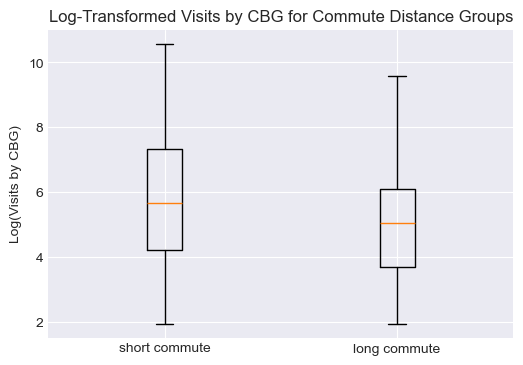

In [90]:
# Apply log transformation to the 'visits_by_cbg' values
short_comute_group = np.log1p(short_comute_pop)  # log1p is used to avoid issues with log(0)
long_comute_group = np.log1p(long_comute_pop)

# Plot the log-transformed data
plt.figure(figsize=(6, 4))
plt.boxplot([short_comute_group, long_comute_group], 
            labels=['short commute','long commute'])
plt.title('Log-Transformed Visits by CBG for Commute Distance Groups')
plt.ylabel('Log(Visits by CBG)')

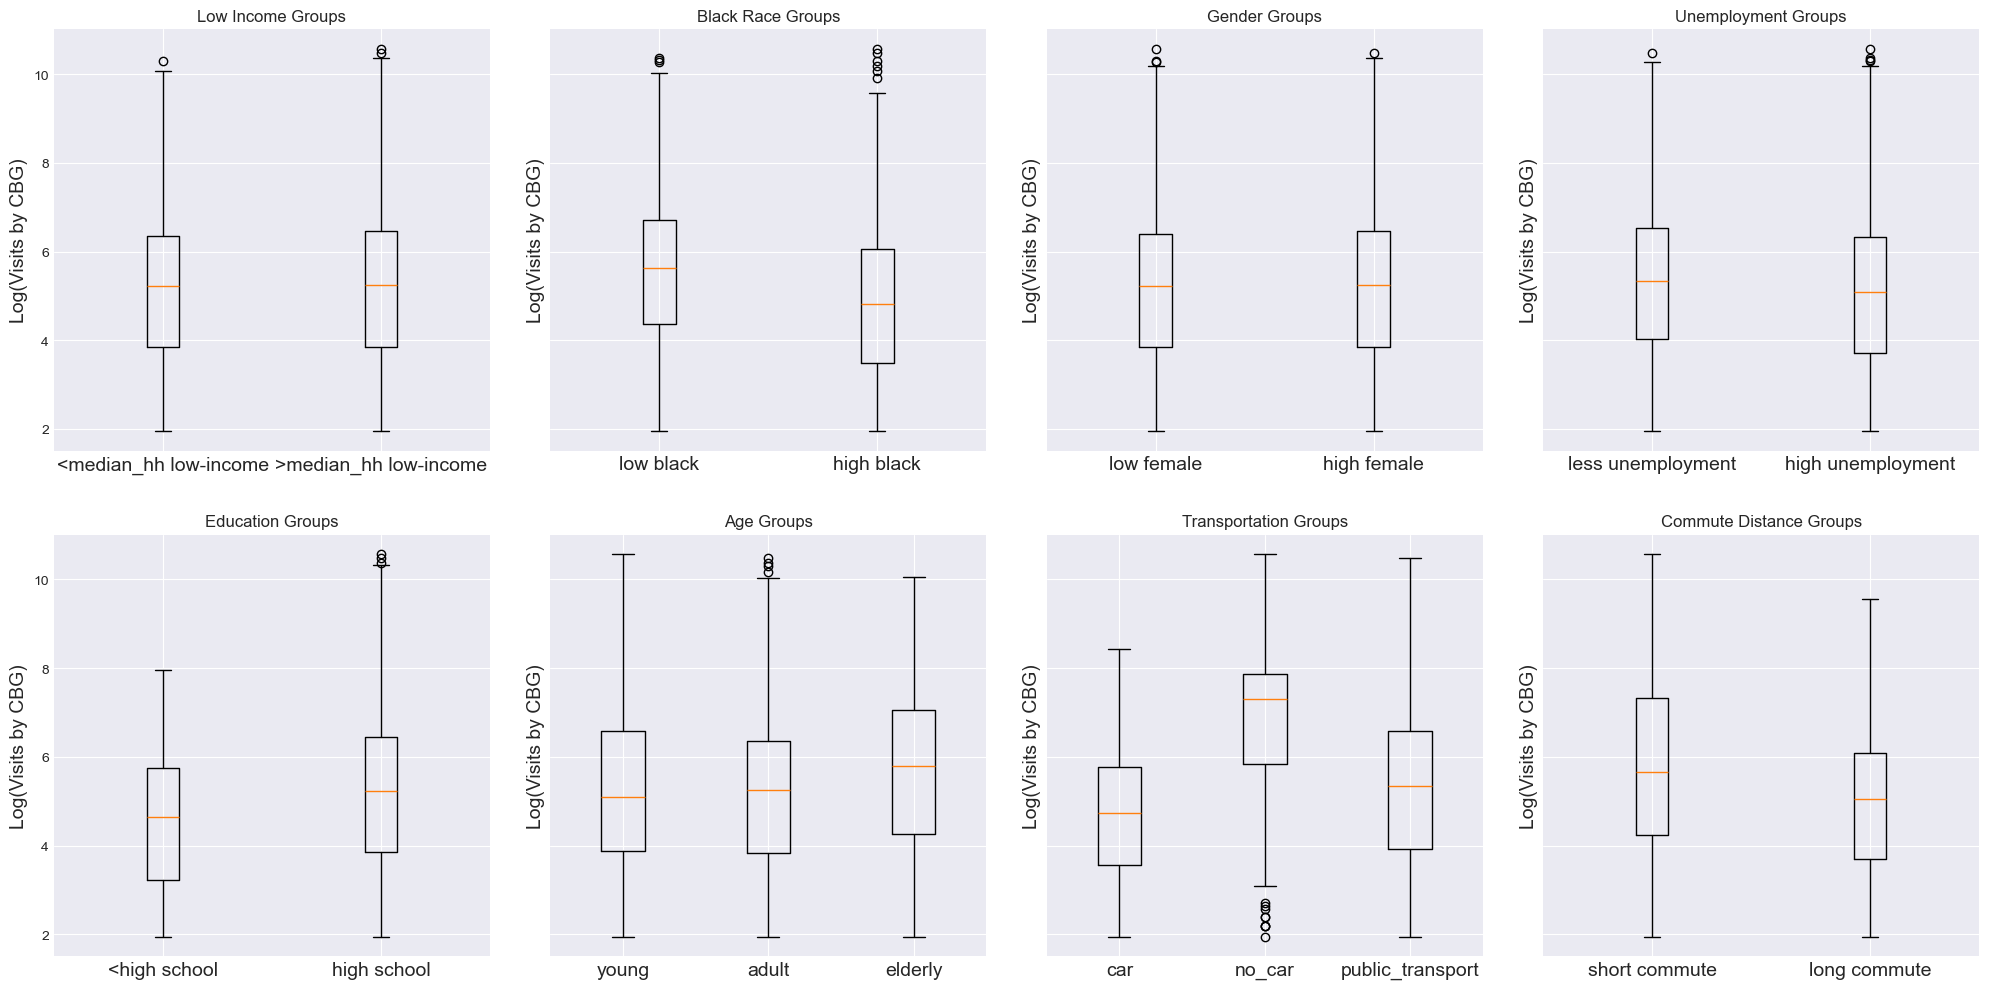

In [91]:
# Set up the figure and the axes for 2 rows and 4 columns
fig, axes = plt.subplots(2, 4, figsize=(20, 10),sharey=True)  # Adjusted to 2 rows and 4 columns

# Plot for Income Groups
axes[0, 0].boxplot([log_group_low_income, log_group_high_income], labels=['<median_hh low-income', '>median_hh low-income'])
axes[0, 0].set_title('Low Income Groups')
axes[0, 0].set_ylabel('Log(Visits by CBG)', fontsize=14)
axes[0, 0].tick_params(axis='x', labelsize=14)

# Plot for Black Race Groups
axes[0, 1].boxplot([log_group_low_black, log_group_high_black], labels=['low black', 'high black'])
axes[0, 1].set_title('Black Race Groups')
axes[0, 1].set_ylabel('Log(Visits by CBG)', fontsize=14)
axes[0, 1].tick_params(axis='x', labelsize=14)

# Plot for Gender Groups
axes[0, 2].boxplot([log_group_low_female, log_group_high_female], labels=['low female', 'high female'])
axes[0, 2].set_title('Gender Groups')
axes[0, 2].set_ylabel('Log(Visits by CBG)', fontsize=14)
axes[0, 2].tick_params(axis='x', labelsize=14)

# Plot for Unemployment Groups
axes[0, 3].boxplot([log_group_low_unemp, log_group_high_unemp], labels=['less unemployment', 'high unemployment'])
axes[0, 3].set_title('Unemployment Groups')
axes[0, 3].set_ylabel('Log(Visits by CBG)', fontsize=14)
axes[0, 3].tick_params(axis='x', labelsize=14)

# Plot for Education Groups
axes[1, 0].boxplot([log_group_less_highsch, log_group_highsch], labels=['<high school', 'high school'])
axes[1, 0].set_title('Education Groups')
axes[1, 0].set_ylabel('Log(Visits by CBG)', fontsize=14)
axes[1, 0].tick_params(axis='x', labelsize=14)

# Plot for Age Groups
axes[1, 1].boxplot([young_group, adult_group, elderly_group], labels=['young', 'adult', 'elderly'])
axes[1, 1].set_title('Age Groups')
axes[1, 1].set_ylabel('Log(Visits by CBG)', fontsize=14)
axes[1, 1].tick_params(axis='x', labelsize=14)

# Plot for Transportation Groups
axes[1, 2].boxplot([car_group, no_car_group, public_trans_group], labels=['car', 'no_car', 'public_transport'])
axes[1, 2].set_title('Transportation Groups')
axes[1, 2].set_ylabel('Log(Visits by CBG)', fontsize=14)
axes[1, 2].tick_params(axis='x', labelsize=14)

# Plot for Commute Distance Groups
axes[1, 3].boxplot([short_comute_group, long_comute_group], labels=['short commute', 'long commute'])
axes[1, 3].set_title('Commute Distance Groups')
axes[1, 3].set_ylabel('Log(Visits by CBG)', fontsize=14)
axes[1, 3].tick_params(axis='x', labelsize=14)

# Adjust layout to make sure everything fits without overlapping
plt.tight_layout()

# Adjust spacing between rows (increase hspace for more space)
plt.subplots_adjust(hspace=0.2)

# Show the plot


## Do sociodemographic variables statistically influence dwell-time in Parks?

### Income category ---> low income

In [93]:
# Group data by subgroup
income_grouped_data = merged_df.groupby('low_income_subgroup')['median_dwell'].apply(list)

# Extract data for ANOVA
income_group1 = income_grouped_data['low_income_low_median']
income_group2 = income_grouped_data['low_income_high_median']

In [94]:
# Check the sizes of the groups
print(f"Low Income Group Size: {len(income_group1)}")
print(f"High Income Group Size: {len(income_group2)}")

Low Income Group Size: 926
High Income Group Size: 2878


In [95]:
## check ANOVA assumption

# 1) normality test 
# 2) test for equal variance

# Normality test
statistic, p_value = stats.shapiro(income_group1)
print("Shapiro-Wilk test for group 1:", statistic, p_value)

# Homogeneity of variances test
statistic, p_value = stats.levene(income_group1, income_group2)
print("Levene's test:", statistic, p_value)

Shapiro-Wilk test for group 1: 0.614442159507461 3.499052465129302e-41
Levene's test: 0.4934781866055703 0.4824228592904465


In [96]:
statistic, p_value = stats.kruskal(income_group1, income_group2)

print("Kruskal-Wallis test:", statistic, p_value)

Kruskal-Wallis test: 4.184290378070108 0.04080029016905569


Text(0, 0.5, 'Log(Park Dwell Time by CBG)')

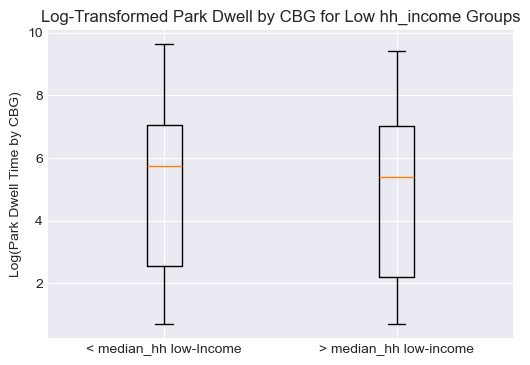

In [97]:
# Apply log transformation to the 'visits_by_cbg' values
log_group_low_income_dwell = np.log1p(income_group1)  # log1p is used to avoid issues with log(0)
log_group_high_income_dwell = np.log1p(income_group2)

# Plot the log-transformed data
plt.figure(figsize=(6, 4))
plt.boxplot([log_group_low_income_dwell, log_group_high_income_dwell], 
            labels=['< median_hh low-Income', '> median_hh low-income'])
plt.title('Log-Transformed Park Dwell by CBG for Low hh_income Groups')
plt.ylabel('Log(Park Dwell Time by CBG)')


## Race Category ---> Black

In [98]:
merged_dwell_black = merged_df.copy()

In [99]:
# Step 1: Create two groups based on the median of 'pct_black'
median_black_threshold = merged_dwell_black['pct_black'].median()

# Create two groups: low percentage of blacks and high percentage of blacks
group_low_black_dwell = merged_dwell_black[merged_dwell_black['pct_black'] < median_black_threshold]['median_dwell']
group_high_black_dwell = merged_dwell_black[merged_dwell_black['pct_black'] >= median_black_threshold]['median_dwell']

In [100]:
statistic, p_value = stats.kruskal(group_low_black_dwell, group_high_black_dwell)

print("Kruskal-Wallis test:", statistic, p_value)

Kruskal-Wallis test: 16.988723807356077 3.760247828193814e-05


Text(0, 0.5, 'Log(Park Dwell Time by CBG)')

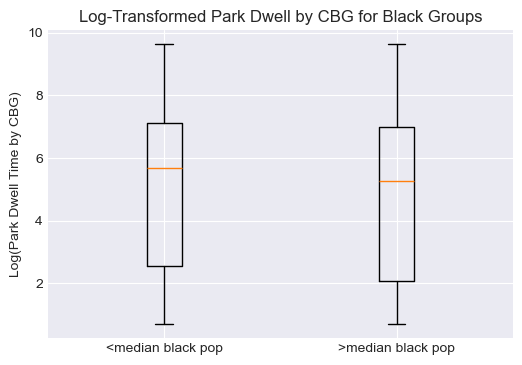

In [101]:
# Apply log transformation to the 'visits_by_cbg' values
log_group_low_black_dwell = np.log1p(group_low_black_dwell)  # log1p is used to avoid issues with log(0)
log_group_high_black_dwell = np.log1p(group_high_black_dwell)

# Plot the log-transformed data
plt.figure(figsize=(6, 4))
plt.boxplot([log_group_low_black_dwell, log_group_high_black_dwell], 
            labels=['<median black pop', '>median black pop'])
plt.title('Log-Transformed Park Dwell by CBG for Black Groups')
plt.ylabel('Log(Park Dwell Time by CBG)')


### Gender ---> Female

In [102]:
# Step 1: Create two groups based on the median of 'pct_female'
median_female = merged_df['pct_female'].median()

# Create two groups: low percentage of females and high percentage of females
group_low_female_dwell = merged_df[merged_df['pct_female'] < median_female]['median_dwell']
group_high_female_dwell = merged_df[merged_df['pct_female'] >= median_female]['median_dwell']

In [103]:
statistic, p_value = stats.kruskal(group_low_female_dwell, group_high_female_dwell)

print("Kruskal-Wallis test:", statistic, p_value)

Kruskal-Wallis test: 3.1961455823998923 0.07381203904165749


Text(0, 0.5, 'Log(Park Dwell Time by CBG)')

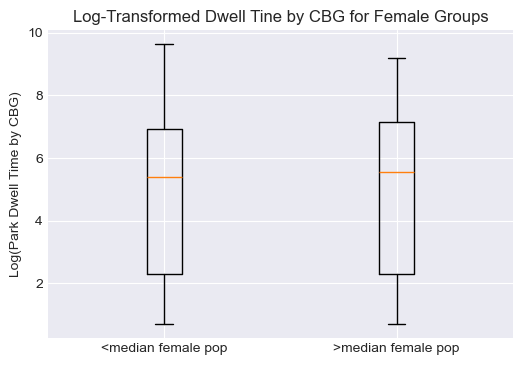

In [104]:
# Apply log transformation to the 'visits_by_cbg' values
log_group_low_female_dwell = np.log1p(group_low_female_dwell)  # log1p is used to avoid issues with log(0)
log_group_high_female_dwell = np.log1p(group_high_female_dwell)

# Plot the log-transformed data
plt.figure(figsize=(6, 4))
plt.boxplot([log_group_low_female_dwell, log_group_high_female_dwell], 
            labels=['<median female pop', '>median female pop'])
plt.title('Log-Transformed Dwell Tine by CBG for Female Groups')
plt.ylabel('Log(Park Dwell Time by CBG)')


### Unemployment

In [105]:
# Step 1: Create two groups based on the median of 'pct_unemp'
median_unemp_dwell = merged_df['pct_unemp'].median()

# Create two groups: low percentage of females and high percentage of females
group_low_unemp_dwell = merged_df[merged_df['pct_unemp'] < median_unemp_dwell]['median_dwell']
group_high_unemp_dwell = merged_df[merged_df['pct_unemp'] >= median_unemp_dwell]['median_dwell']

In [106]:
statistic, p_value = stats.kruskal(group_low_unemp_dwell, group_high_unemp_dwell)

print("Kruskal-Wallis test:", statistic, p_value)

Kruskal-Wallis test: 4.327055026787557 0.03751109336121893


Text(0, 0.5, 'Log(Park Dwell Time by CBG)')

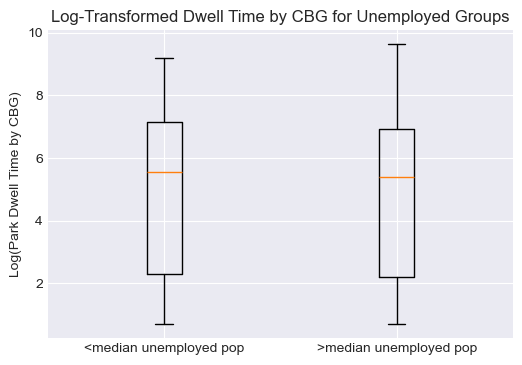

In [107]:
# Apply log transformation to the 'visits_by_cbg' values
log_group_low_unemp_dwell = np.log1p(group_low_unemp_dwell)  # log1p is used to avoid issues with log(0)
log_group_high_unemp_dwell = np.log1p(group_high_unemp_dwell)

# Plot the log-transformed data
plt.figure(figsize=(6, 4))
plt.boxplot([log_group_low_unemp_dwell, log_group_high_unemp_dwell], 
            labels=['<median unemployed pop', '>median unemployed pop'])
plt.title('Log-Transformed Dwell Time by CBG for Unemployed Groups')
plt.ylabel('Log(Park Dwell Time by CBG)')

### Education category ---> Less than highschool + highschool

In [108]:
merged_df_edu_dwell = merged_df.copy()

In [109]:
# Create a new column to categorize rows based on education level
merged_df_edu_dwell['education_category'] = merged_df_edu_dwell.apply(lambda row: 'low_edu' if row['pct_low_edu'] > row['pct_high_edu'] else ('high_edu' if row['pct_high_edu'] > row['pct_low_edu'] else 'mixed'), axis=1)

In [110]:
less_highsch_dwell = merged_df_edu_dwell[merged_df_edu_dwell['education_category']=='low_edu']['median_dwell']
highsch_dwell = merged_df_edu_dwell[merged_df_edu_dwell['education_category']=='high_edu']['median_dwell']

In [111]:
statistic, p_value = stats.kruskal(less_highsch_dwell, highsch_dwell)

print("Kruskal-Wallis test:", statistic, p_value)

Kruskal-Wallis test: 3.855773404824975 0.049575065756412164


Text(0, 0.5, 'Log(Park Dwell Time by CBG)')

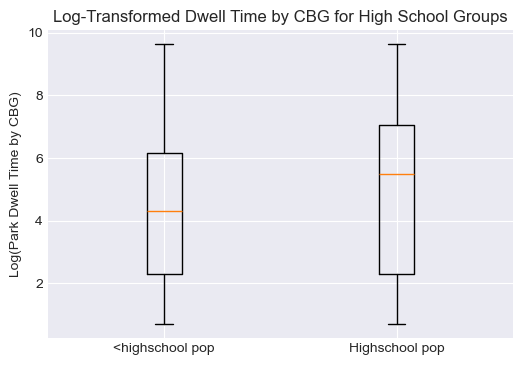

In [112]:
# Apply log transformation to the 'visits_by_cbg' values
log_group_less_highsch_dwell = np.log1p(less_highsch_dwell)  # log1p is used to avoid issues with log(0)
log_group_highsch_dwell = np.log1p(highsch_dwell)

# Plot the log-transformed data
plt.figure(figsize=(6, 4))
plt.boxplot([log_group_less_highsch_dwell, log_group_highsch_dwell], 
            labels=['<highschool pop', 'Highschool pop'])
plt.title('Log-Transformed Dwell Time by CBG for High School Groups')
plt.ylabel('Log(Park Dwell Time by CBG)')

### Age category

In [113]:
merged_age_dwell = merged_df.copy()

In [114]:
def categorize_age(row):
    if row['pct_young'] > row['pct_elderly'] and row['pct_young'] > row['pct_adult']:
        return 'young'
    elif row['pct_adult'] > row['pct_elderly'] and row['pct_adult'] > row['pct_young']:
        return 'adult'
    elif row['pct_elderly'] > row['pct_young'] and row['pct_elderly'] > row['pct_adult']:
        return 'elderly'
    else:
        return 'mix'


merged_age_dwell['age_category'] = merged_age_dwell.apply(categorize_age,axis=1)

In [115]:
young_pop_dwell = merged_age_dwell[merged_age_dwell['age_category'] == 'young']['median_dwell']
adult_pop_dwell = merged_age_dwell[merged_age_dwell['age_category'] == 'adult']['median_dwell']
elderly_pop_dwell = merged_age_dwell[merged_age_dwell['age_category'] == 'elderly']['median_dwell']

In [116]:

statistic, p_value = stats.kruskal(young_pop_dwell, adult_pop_dwell,elderly_pop_dwell)

print("Kruskal-Wallis test:", statistic, p_value)

Kruskal-Wallis test: 16.75399504224488 0.0002300997790582042


Text(0, 0.5, 'Log(Park Dwell by CBG)')

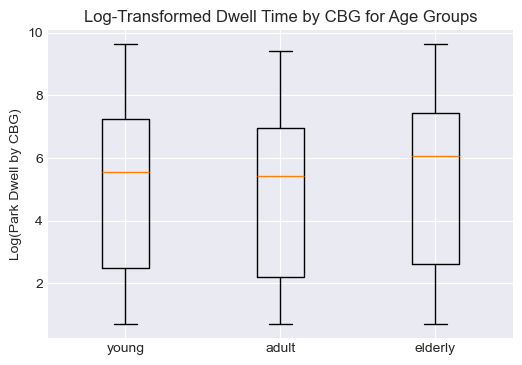

In [117]:
# Apply log transformation to the 'visits_by_cbg' values
young_group_dwell = np.log1p(young_pop_dwell)  # log1p is used to avoid issues with log(0)
adult_group_dwell = np.log1p(adult_pop_dwell)
elderly_group_dwell = np.log1p(elderly_pop_dwell)

# Plot the log-transformed data
plt.figure(figsize=(6, 4))
plt.boxplot([young_group_dwell, adult_group_dwell,elderly_group_dwell], 
            labels=['young', 'adult','elderly'])
plt.title('Log-Transformed Dwell Time by CBG for Age Groups')
plt.ylabel('Log(Park Dwell by CBG)')

### Transportation 

In [118]:
merged_transport_dwell = merged_df.copy()

In [119]:
def categorize_transport(row):
    if row['pct_car'] > row['pct_0car'] and row['pct_car'] > row['pct_public_trans']:
        return 'car'
    elif row['pct_0car'] > row['pct_car'] and row['pct_0car'] > row['pct_public_trans']:
        return 'no_car'
    elif row['pct_public_trans'] > row['pct_car'] and row['pct_public_trans'] > row['pct_0car']:
        return 'public_trans'
    else:
        return 'mixed'  # In case of ties or equal values

# Apply the function to each row in the DataFrame to create the 'transport_category' column
merged_transport_dwell['transport_category'] = merged_transport_dwell.apply(categorize_transport, axis=1)

In [120]:
car_pop_dwell = merged_transport_dwell[merged_transport_dwell['transport_category'] == 'car']['median_dwell']
no_car_pop_dwell = merged_transport_dwell[merged_transport_dwell['transport_category'] == 'no_car']['median_dwell']
public_trans_pop_dwell = merged_transport_dwell[merged_transport_dwell['transport_category'] == 'public_trans']['median_dwell']

In [121]:
statistic, p_value = stats.kruskal(car_pop_dwell, no_car_pop_dwell,public_trans_pop_dwell)

print("Kruskal-Wallis test:", statistic, p_value)

Kruskal-Wallis test: 332.7252503882451 5.6186228783711285e-73


Text(0, 0.5, 'Log(Park Dwell by CBG)')

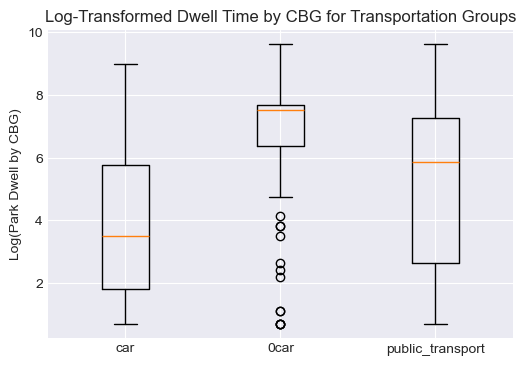

In [122]:
# Apply log transformation to the 'visits_by_cbg' values
car_group_dwell = np.log1p(car_pop_dwell)  # log1p is used to avoid issues with log(0)
no_car_group_dwell = np.log1p(no_car_pop_dwell)
public_trans_group_dwell = np.log1p(public_trans_pop_dwell)

# Plot the log-transformed data
plt.figure(figsize=(6, 4))
plt.boxplot([car_group_dwell, no_car_group_dwell,public_trans_group_dwell], 
            labels=['car', '0car','public_transport'])
plt.title('Log-Transformed Dwell Time by CBG for Transportation Groups')
plt.ylabel('Log(Park Dwell by CBG)')

### Commute Distance

In [123]:
merged_commute_dwell = merged_df.copy()

In [124]:
# define a function that creates commute_category and returns the dominant commute in any row

def categorize_commute(row):
    if row['pct_short_comute'] > row['pct_long_comute'] and row['pct_short_comute'] >=70:
        return 'pct_short_comute'
    else:
        return 'pct_long_comute'

merged_commute_dwell['commute_category'] = merged_commute_dwell.apply(categorize_commute,axis=1)

In [125]:
short_comute_pop_dwell = merged_commute_dwell[merged_commute_dwell['commute_category'] == 'pct_short_comute']['median_dwell']
long_comute_pop_dwell = merged_commute_dwell[merged_commute_dwell['commute_category'] == 'pct_long_comute']['median_dwell']

In [126]:
statistic, p_value = stats.kruskal(short_comute_pop_dwell, long_comute_pop_dwell)

print("Kruskal-Wallis test:", statistic, p_value)

Kruskal-Wallis test: 147.4568022315511 6.235524633250554e-34


Text(0, 0.5, 'Log(Park Dwell by CBG)')

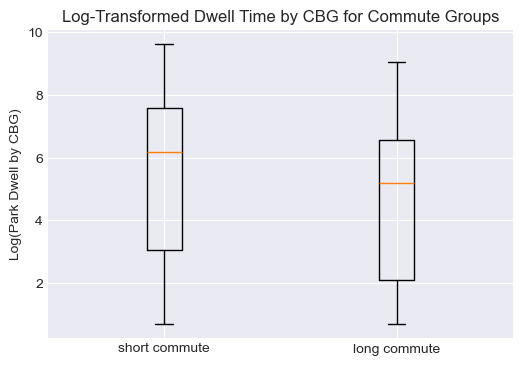

In [127]:
# Apply log transformation to the 'visits_by_cbg' values
short_comute_group_dwell = np.log1p(short_comute_pop_dwell)  # log1p is used to avoid issues with log(0)
long_comute_group_dwell = np.log1p(long_comute_pop_dwell)

# Plot the log-transformed data
plt.figure(figsize=(6, 4))
plt.boxplot([short_comute_group_dwell, long_comute_group_dwell], 
            labels=['short commute','long commute'])
plt.title('Log-Transformed Dwell Time by CBG for Commute Groups')
plt.ylabel('Log(Park Dwell by CBG)')

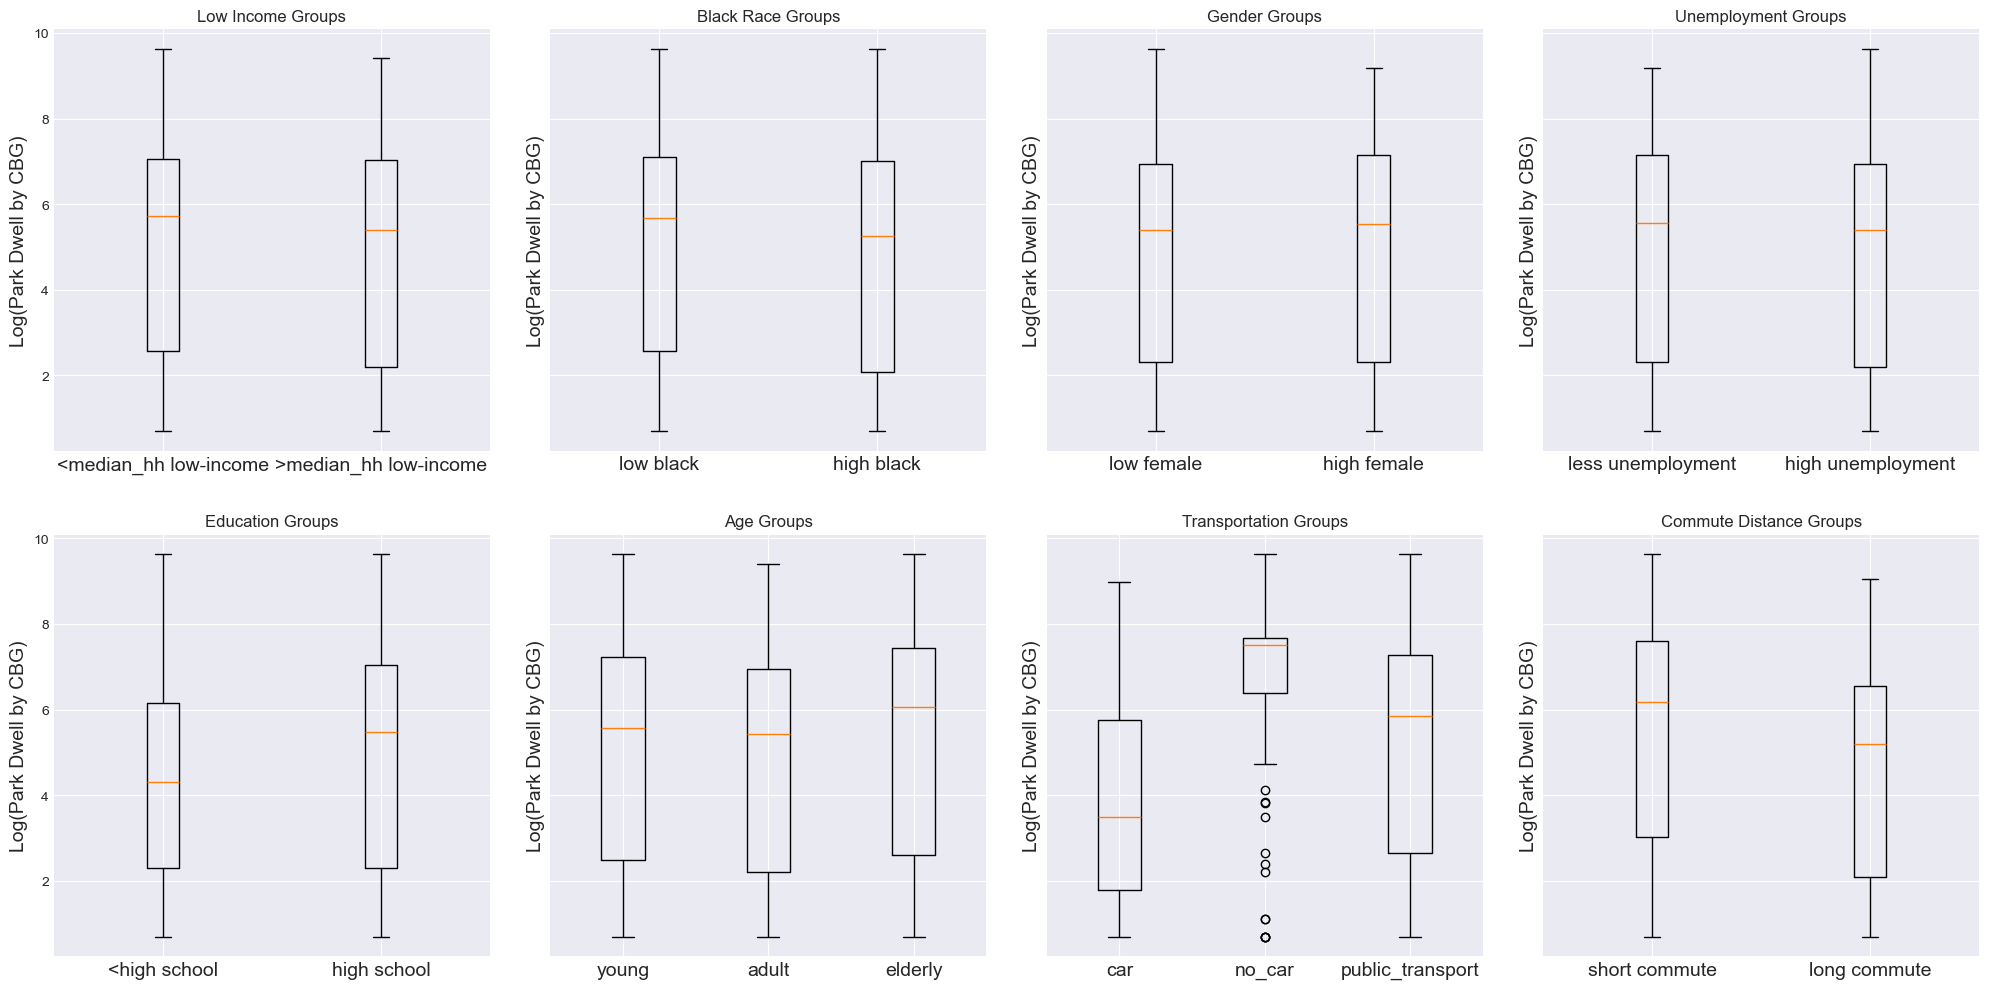

In [128]:
# Set up the figure and the axes for 2 rows and 4 columns
fig, axes = plt.subplots(2, 4, figsize=(20, 10),sharey=True)  # Adjusted to 2 rows and 4 columns

# Plot for Income Groups
axes[0, 0].boxplot([log_group_low_income_dwell, log_group_high_income_dwell], labels=['<median_hh low-income', '>median_hh low-income'])
axes[0, 0].set_title('Low Income Groups')
axes[0, 0].set_ylabel('Log(Park Dwell by CBG)', fontsize=14)
axes[0, 0].tick_params(axis='x', labelsize=14)

# Plot for Black Race Groups
axes[0, 1].boxplot([log_group_low_black_dwell, log_group_high_black_dwell], labels=['low black', 'high black'])
axes[0, 1].set_title('Black Race Groups')
axes[0, 1].set_ylabel('Log(Park Dwell by CBG)', fontsize=14)
axes[0, 1].tick_params(axis='x', labelsize=14)

# Plot for Gender Groups
axes[0, 2].boxplot([log_group_low_female_dwell, log_group_high_female_dwell], labels=['low female', 'high female'])
axes[0, 2].set_title('Gender Groups')
axes[0, 2].set_ylabel('Log(Park Dwell by CBG)', fontsize=14)
axes[0, 2].tick_params(axis='x', labelsize=14)

# Plot for Unemployment Groups
axes[0, 3].boxplot([log_group_low_unemp_dwell, log_group_high_unemp_dwell], labels=['less unemployment', 'high unemployment'])
axes[0, 3].set_title('Unemployment Groups')
axes[0, 3].set_ylabel('Log(Park Dwell by CBG)', fontsize=14)
axes[0, 3].tick_params(axis='x', labelsize=14)

# Plot for Education Groups
axes[1, 0].boxplot([log_group_less_highsch_dwell, log_group_highsch_dwell], labels=['<high school', 'high school'])
axes[1, 0].set_title('Education Groups')
axes[1, 0].set_ylabel('Log(Park Dwell by CBG)', fontsize=14)
axes[1, 0].tick_params(axis='x', labelsize=14)

# Plot for Age Groups
axes[1, 1].boxplot([young_group_dwell, adult_group_dwell, elderly_group_dwell], labels=['young', 'adult', 'elderly'])
axes[1, 1].set_title('Age Groups')
axes[1, 1].set_ylabel('Log(Park Dwell by CBG)', fontsize=14)
axes[1, 1].tick_params(axis='x', labelsize=14)

# Plot for Transportation Groups
axes[1, 2].boxplot([car_group_dwell, no_car_group_dwell, public_trans_group_dwell], labels=['car', 'no_car', 'public_transport'])
axes[1, 2].set_title('Transportation Groups')
axes[1, 2].set_ylabel('Log(Park Dwell by CBG)', fontsize=14)
axes[1, 2].tick_params(axis='x', labelsize=14)

# Plot for Commute Distance Groups
axes[1, 3].boxplot([short_comute_group_dwell, long_comute_group_dwell], labels=['short commute', 'long commute'])
axes[1, 3].set_title('Commute Distance Groups')
axes[1, 3].set_ylabel('Log(Park Dwell by CBG)', fontsize=14)
axes[1, 3].tick_params(axis='x', labelsize=14)

# Adjust layout to make sure everything fits without overlapping
plt.tight_layout()

# Adjust spacing between rows (increase hspace for more space)
plt.subplots_adjust(hspace=0.2)

# Show the plot
#plt.savefig('boxplot_medianDwell.png',dpi=300)


## 2) Investigating Low visits CBGs

In [129]:
# Chi-Square test
from scipy.stats import chi2_contingency

In [130]:
low_visitor_cbg = pd.merge(socio_df_1,low_visitor_home_cbg, left_on='FIPS', right_on='visitor_home_cbg')

In [131]:
high_visitor_cbg = pd.merge(socio_df_1,high_visitor_home_cbg, left_on='FIPS', right_on='visitor_home_cbg')

In [132]:
cbgs_joint_analysis = merged_df.copy() 

In [133]:
## create a column for visit_type [low_visit, high_visit]

def visit_volume(row):
    if row['visits_by_cbg'] <= 300:
        return 'low_visit'
    else:
        return 'high_visit'

cbgs_joint_analysis['visit_type'] = cbgs_joint_analysis.apply(visit_volume,axis=1)

### Comparing low vs high visits CBGs for race

In [134]:
# create a function to include the dominant race in a cbg

def race_dominance(row):
    if row['pct_white'] > row['pct_black'] and row['pct_white'] > row['pct_asian'] and row['pct_white'] > row['pct_others']:
        return 'white'
    elif row['pct_black'] > row['pct_white'] and row['pct_black'] > row['pct_asian'] and row['pct_black'] > row['pct_others']:
        return 'black'
    elif row['pct_asian'] > row['pct_black'] and row['pct_asian'] > row['pct_white'] and row['pct_asian'] > row['pct_others']:
        return 'asian'
    elif row['pct_others'] > row['pct_black'] and row['pct_others'] > row['pct_asian'] and row['pct_others'] > row['pct_white']:
        return 'others'

cbgs_joint_analysis['race_type'] = cbgs_joint_analysis.apply(race_dominance,axis=1)

In [135]:
# Create a contingency table
contingency_table = pd.crosstab(cbgs_joint_analysis['race_type'], cbgs_joint_analysis['visit_type'])  # visit_category could be 'low' or 'high'

# Perform Chi-Square test
statistic, p_value, dof, expected = chi2_contingency(contingency_table)
print("Chi-Square Test:", statistic, p_value)

Chi-Square Test: 128.75737459816165 1.001963721042012e-27


In [136]:
print(contingency_table)

visit_type  high_visit  low_visit
race_type                        
asian              157        262
black              239        664
others             176        337
white              943       1024


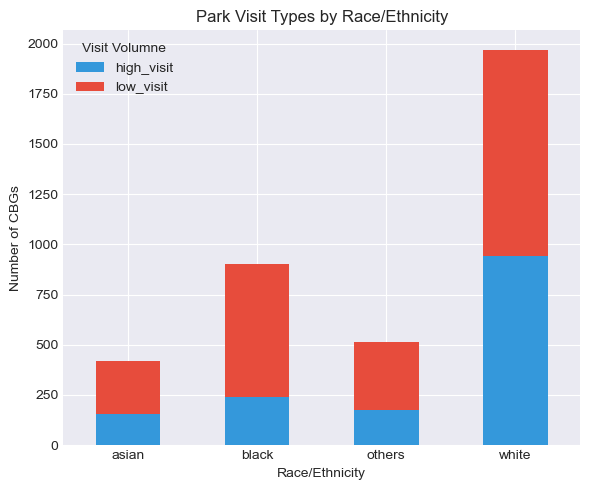

In [137]:
# Plot the contingency table as a stacked bar plot
contingency_table.plot(kind='bar', stacked=True, figsize=(6, 5), color=['#3498db', '#e74c3c'])

plt.title('Park Visit Types by Race/Ethnicity')
plt.xlabel('Race/Ethnicity')
plt.ylabel('Number of CBGs')
plt.xticks(rotation=0)
plt.legend(title='Visit Volumne', loc='upper left')
plt.tight_layout()

### Comparing income disparity

In [138]:
# Assuming 'visit_type' already categorizes CBGs into 'low_visit' and 'high_visit'
low_visit_cbgs = cbgs_joint_analysis[cbgs_joint_analysis['visit_type'] == 'low_visit']
high_visit_cbgs = cbgs_joint_analysis[cbgs_joint_analysis['visit_type'] == 'high_visit']

In [139]:
# Calculate median income for low-visit CBGs
low_visit_median_income = low_visit_cbgs['median_income'].mean()

# Calculate median income for high-visit CBGs
high_visit_median_income = high_visit_cbgs['median_income'].mean()

# Print the results
print(f"Mean Median Income for Low-Visit CBGs: {low_visit_median_income}")
print(f"Mean Median Income for High-Visit CBGs: {high_visit_median_income}")

Mean Median Income for Low-Visit CBGs: 87360.93181818182
Mean Median Income for High-Visit CBGs: 99675.98482849605


In [154]:
# Perform Statistical Test (Mann Whitney U Test)

from scipy.stats import mannwhitneyu

# Perform Mann-Whitney U Test
stat, p_value = mannwhitneyu(low_visit_cbgs['median_income'], high_visit_cbgs['median_income'])

# Print the result
print(f"Mann-Whitney U Test Statistic: {stat}, p-value: {p_value}")

Mann-Whitney U Test Statistic: 1605240.5, p-value: 9.954238882080314e-05


Text(0, 0.5, 'Median Income')

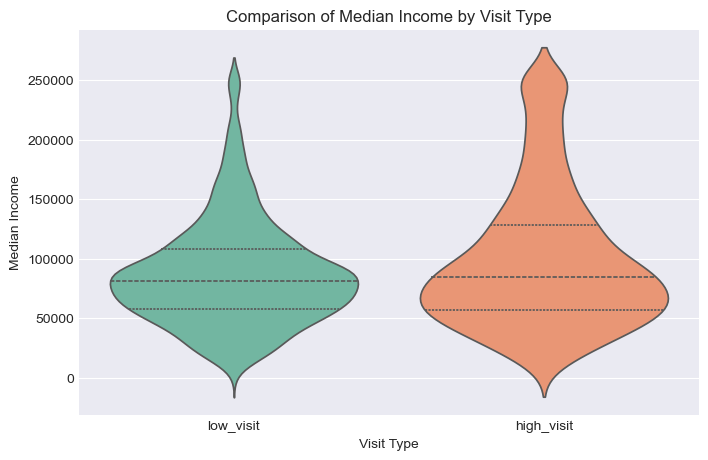

In [155]:
# Combine the two DataFrames into one for easier plotting
income_data = cbgs_joint_analysis[['visit_type', 'median_income']]

# Plot a box plot to compare income levels
plt.figure(figsize=(8, 5))
sns.violinplot(x='visit_type', y='median_income', data=income_data, inner="quartile", palette="Set2",hue='visit_type')
plt.title('Comparison of Median Income by Visit Type')
plt.xlabel('Visit Type')
plt.ylabel('Median Income')

### comparing age distribution

Low-Visit CBG Age Statistics:
         pct_young    pct_adult  pct_elderly
count  2288.000000  2288.000000  2288.000000
mean     34.167959    47.264244    18.567780
std      12.369687    12.059706    11.002167
min       0.000000     0.000000     0.000000
25%      25.497500    39.982500    10.867500
50%      33.400000    47.705000    16.940000
75%      41.870000    55.272500    24.420000
max      87.130000    83.800000    85.010000

High-Visit CBG Age Statistics:
         pct_young    pct_adult  pct_elderly
count  1516.000000  1516.000000  1516.000000
mean     33.716029    46.397639    19.886036
std      14.208531    12.677934    12.173308
min       0.000000     0.000000     0.000000
25%      23.665000    39.115000    11.205000
50%      32.400000    47.155000    17.850000
75%      41.590000    54.665000    26.262500
max     100.000000    87.650000    87.800000


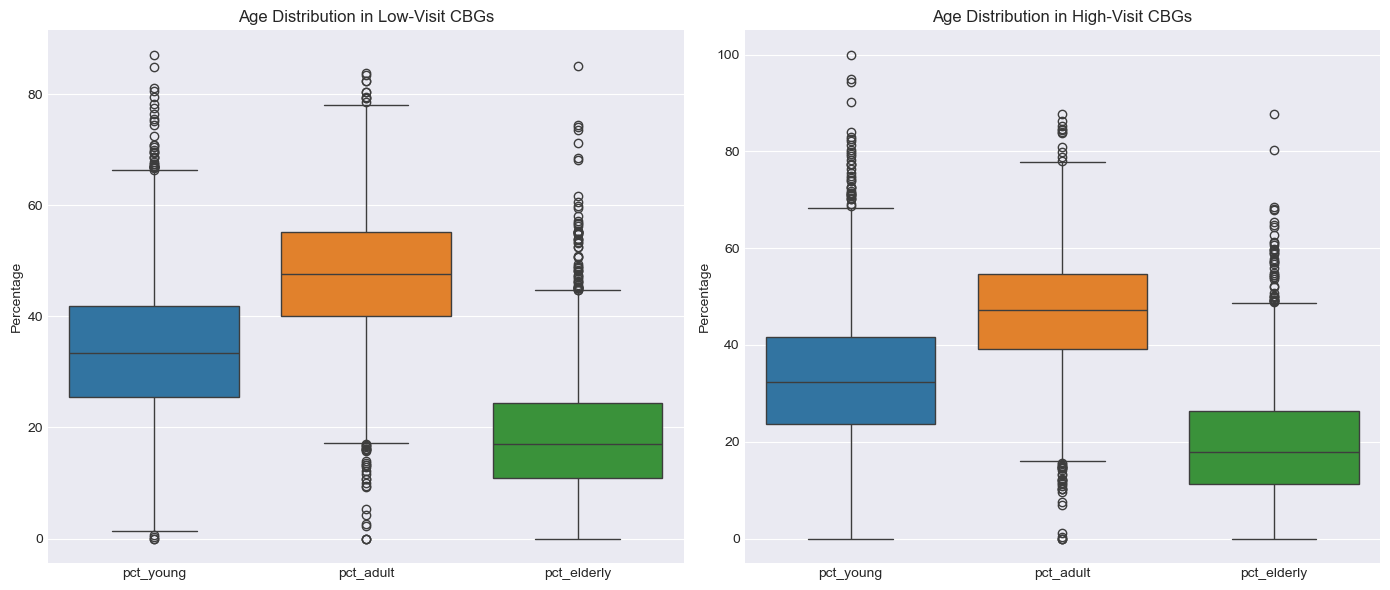

In [156]:
# Calculate descriptive statistics for age groups in low-visit CBGs
low_visit_age_stats = low_visitor_cbg[['pct_young', 'pct_adult', 'pct_elderly']].describe()

# Calculate descriptive statistics for age groups in high-visit CBGs
high_visit_age_stats = high_visitor_cbg[['pct_young', 'pct_adult', 'pct_elderly']].describe()

print("Low-Visit CBG Age Statistics:")
print(low_visit_age_stats)

print("\nHigh-Visit CBG Age Statistics:")
print(high_visit_age_stats)

# Visualize the age distribution in low-visit and high-visit CBGs using boxplots
plt.figure(figsize=(14, 6))

# Plot for Low-Visit CBGs
plt.subplot(1, 2, 1)
sns.boxplot(data=low_visitor_cbg[['pct_young', 'pct_adult', 'pct_elderly']])
plt.title('Age Distribution in Low-Visit CBGs')
plt.ylabel('Percentage')

# Plot for High-Visit CBGs
plt.subplot(1, 2, 2)
sns.boxplot(data=high_visitor_cbg[['pct_young', 'pct_adult', 'pct_elderly']])
plt.title('Age Distribution in High-Visit CBGs')
plt.ylabel('Percentage')

plt.tight_layout()

### Location analysis

In [157]:
Manhattan = low_visitor_cbg[low_visitor_cbg['FIPS'].str.match('36061')].shape

In [158]:
# 36085|36047|36081|36061|36005
Bronx = low_visitor_cbg[low_visitor_cbg['FIPS'].str.match('36005')].shape

In [159]:
Queens = low_visitor_cbg[low_visitor_cbg['FIPS'].str.match('36081')].shape

In [146]:
Brooklyn = low_visitor_cbg[low_visitor_cbg['FIPS'].str.match('36047')].shape

In [147]:
Staten_Island = low_visitor_cbg[low_visitor_cbg['FIPS'].str.match('36085')].shape

In [148]:
# High visit Boroughs
Manhattan1 = high_visitor_cbg[high_visitor_cbg['FIPS'].str.match('36061')].shape

In [149]:
Bronx1 = high_visitor_cbg[high_visitor_cbg['FIPS'].str.match('36005')].shape

In [150]:
Queens1 = high_visitor_cbg[high_visitor_cbg['FIPS'].str.match('36081')].shape

In [151]:
Brooklyn1 = high_visitor_cbg[high_visitor_cbg['FIPS'].str.match('36047')].shape

In [152]:
Staten_Island1 = high_visitor_cbg[high_visitor_cbg['FIPS'].str.match('36085')].shape